# Characteristic Words

A notebook to explore the distribution of characterising / high frequency / function words in different corpora.

In [1]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import time
from collections import defaultdict
import operator,math
from gensim.models import Word2Vec
import math

import nlp_tools

Functions to find the high frequency (ranked higher than k) distribution for a corpus and display the very highest frequency words (ranked higher than cutoff)

In [2]:
#For a given set of corpora, find the frequency distribution of the k highest frequency words
#Output total size of corpus and sorted list of term, frequency pairs

def find_hfw_dist(corpora,k=100000):
    #add worddicts for individual corpora
    #sort and output highest frequency words
    #visualise
    
    sumdict={}
    corpussize=0
    for acorpus in corpora:
        for(key,value) in acorpus.allworddict.items():
            sumdict[key.lower()]=sumdict.get(key.lower(),0)+value
            corpussize+=value
      
    print("Size of corpus is {}".format(corpussize))
    candidates=sorted(sumdict.items(),key=operator.itemgetter(1),reverse=True)
    #print(candidates[:50])
    #print(len(sumdict))
    #print(sumdict)
    return corpussize,candidates[:k]
        
  

In [3]:
#display the most frequent words in 1 or 2 high frequency word distributions

def display(hfw,cutoff=10,words=[],hfb=None,leg=None):
    width=0.7
    corpussize=hfw[0]
    if words==[]:
        todisplay=hfw[1][:cutoff]
    else:
        todisplay=[(x,y) for (x,y) in hfw[1] if x in words]
        cutoff=len(words)
    barvalues=sorted(todisplay,key=operator.itemgetter(0),reverse=False)
    #print(barvalues)
    xs,ys=[*zip(*barvalues)]
    ps=[y/corpussize for y in ys]
    
    toplot=[ps]
    if hfb!=None:
        width=0.35
        corpussizeb=hfb[0]
        if words==[]:
            todisplayb=hfb[1][:cutoff]
        else:
            todisplayb=[(x,y) for (x,y) in hfb[1] if x in words]
        barb=sorted(todisplayb,key=operator.itemgetter(0),reverse=False)
        
        xb,yb=[*zip(*barb)]
        pb=[y/corpussizeb for y in yb]
        
        toplot.append(pb)
        
    
    N=len(xs)
    ind=np.arange(N)
    fig,ax=plt.subplots(figsize=(cutoff,cutoff/4))
    
    rects1=ax.bar(ind,ps,width,color='r')
    if hfb!=None:
        rects2=ax.bar(ind+width,pb,width,color='b')
        if leg==None:
            ax.legend((rects1,rects2),("Dist1","Dist2"))
        else:
            ax.legend((rects1,rects2),leg)
    ax.set_xticks(ind)
    ax.set_xticklabels(xs)
    ax.set_xlabel('High Frequency Words')
    ax.set_ylabel('Probability')
    
    
    return xs
    


# Differences Between Female and Male Non-Legal Speech in 1800-1820

We are interested in the period 1800-1820.  We are interested in non-legal speech (witness and defendants) in 'theft' trials (which make up the bulk of the trials).  These are split into female and male (by speaker)

In [4]:
p=100
nlp=spacy.load('en')
female_nonlegal=['corpus_1800_1820_theft_f_def','corpus_1800_1820_theft_f_wv']
male_nonlegal=['corpus_1800_1820_theft_m_def','corpus_1800_1820_theft_m_wv']

female_corpus=nlp_tools.corpus(female_nonlegal,nlp,prop=p,ner=False)
male_corpus=nlp_tools.corpus(male_nonlegal,nlp,prop=p,ner=False)

Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 488
Completed 488 docs (10.006151322534345% complete)
Completed 976 docs (20.01230264506869% complete)
Completed 1464 docs (30.018453967603033% complete)
Completed 1952 docs (40.02460529013738% complete)
Completed 2440 docs (50.03075661267172% complete)
Completed 2928 docs (60.03690793520607% complete)
Completed 3416 docs (70.04305925774041% complete)
Completed 3904 docs (80.04921058027476% complete)
Completed 4392 docs (90.05536190280911% complete)
Number of documents is 4877
Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 2228
Completed 2228 docs (10.000897746655895% complete)
Completed 4456 docs (20.00179549331179% complete)
Completed 6684 docs (30.00269323996768% complete)
Completed 8912 docs (40.00359098662358% complete)
Completed 11140 docs (50.004488733279466% complete)
Completed 13368 docs (60.00538647993536% complete)
Completed 15596 docs (70.00628422659126% complete)
Completed 

Lets look at the top 20 most frequent words across the whole corpus (i.e., males and males taken together).

Size of corpus is 1364054


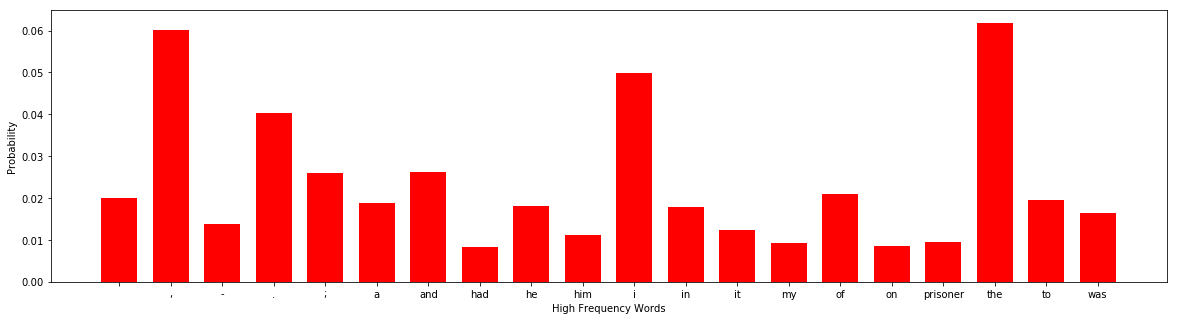

In [5]:
hfw_theft=find_hfw_dist([male_corpus,female_corpus],k=100000)
function_words_theft=display(hfw_theft,cutoff=20)

Now lets compare the distributions of these words for males and females.

Size of corpus is 229558
Size of corpus is 1134496


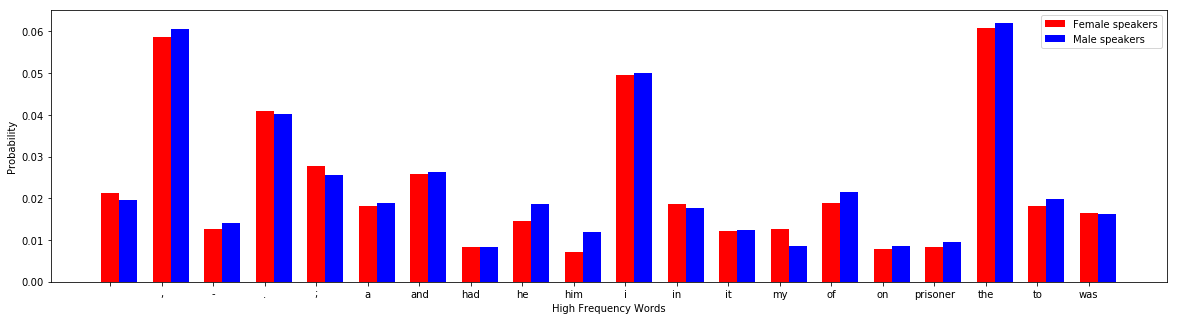

In [6]:
hff_theft=find_hfw_dist([female_corpus])
hfm_theft=find_hfw_dist([male_corpus])
some_words=display(hff_theft,words=function_words_theft,hfb=hfm_theft,leg=['Female speakers','Male speakers'])

There are minimal differences between the distributions. 'of', 'to', 'him','he' and 'the' appear more often for male speakers.  Some punctuation and 'my' appears more often for female speakers.

We want to be able to find the characteristic words for a corpus (i.e., words which occur more often than one would expect by chance).  We can do this using PMI and/or likelihood lift ratio - but it is conventional in work on comparing corpora to use log-likelihood-ratio (LLR (Dunning, 1993)) as this is less biased towards low frequency events than PMI and doesn't require any parameters to be set.

In [7]:
def makedict(alist):
    adict={}
    for (key,value) in alist:
        adict[key]=adict.get(key,0)+value
    return adict
        

def pmi(wordfreq,refwordfreq,corpussize,refcorpussize):
    if wordfreq*refcorpussize*refwordfreq*corpussize==0:
        score=0
#        print(wordfreq,refwordfreq,corpussize,refcorpussize)
    else:
        score=np.log((wordfreq*refcorpussize)/(refwordfreq*corpussize))
    return score


def rev_pmi(wordfreq,refwordfreq,corpussize,refcorpussize):
    return pmi(refwordfreq-wordfreq, refwordfreq,refcorpussize-corpussize,refcorpussize)
        
def llr(wordfreq,refwordfreq,corpussize,refcorpussize):
    
    #print(wordfreq,refwordfreq,corpussize,refcorpussize)
    mypmi=pmi(wordfreq,refwordfreq,corpussize,refcorpussize)
    myrevpmi=rev_pmi(wordfreq,refwordfreq,corpussize,refcorpussize)
    #myrevpmi2=rev_pmi2(wordfreq,refwordfreq,corpussize,refcorpussize)
    #print(mypmi,myrevpmi,myrevpmi2)
    llr_score=2*(wordfreq*mypmi+(refwordfreq-wordfreq)*myrevpmi)
    if pmi(wordfreq,refwordfreq,corpussize,refcorpussize)<0:
        return -llr_score
    else:
        return llr_score

def klp(p,q):
    return p*np.log((2*p)/(p+q))
    
    
def kl(wordfreq,refwordfreq,corpussize,refcorpussize):
    #ref should be the total corpus - function works out difference
    
    p=wordfreq/corpussize
    q=(refwordfreq-wordfreq)/(refcorpussize-corpussize)

    return klp(p,q)

def jsd(wordfreq,refwordfreq,corpussize,refcorpussize):
    p=wordfreq/corpussize
    q=(refwordfreq-wordfreq)/(refcorpussize-corpussize)
    
    k1=klp(p,q)
    k2=klp(q,p)
    score=0.5*(k1+k2)
    if p>q:
        return score
    else:
        return -score
    
    
def likelihoodlift(wordfreq,refwordfreq,corpussize,refcorpussize,alpha):
    beta=0
    if alpha==1:
        return math.log(wordfreq/corpussize)
    elif alpha==0:
        return pmi(wordfreq,refwordfreq,corpussize,refcorpussize)
    else:
        return(alpha*math.log(beta+(wordfreq/corpussize))+(1-alpha)*pmi(wordfreq,refwordfreq,corpussize,refcorpussize))

def mysurprise(wf,rwf,cs,rcs,measure,params):
    if measure=='pmi':
        return pmi(wf,rwf,cs,rcs)
    elif measure=='llr':
        return llr(wf,rwf,cs,rcs)
    elif measure=='kl':
        return kl(wf,rwf,cs,rcs)
    elif measure=='jsd':
        return jsd(wf,rwf,cs,rcs)
    elif measure =='likelihoodlift':
        return likelihoodlift(wf,rwf,cs,rcs,params.get('alpha',0.5))
    else:
        print("Unknown measure of surprise")

def improved_compute_surprises(corpusA,corpusB,measure,params={}):
    (corpusAsize,wordlistA)=corpusA
    (corpusBsize,wordlistB)=corpusB
    if 'threshold' in params.keys():
        threshold=params['threshold']
    else:
        threshold=len(wordlistA)
    #dictA=makedict(wordlistA)
    dictB=makedict(wordlistB)
    
    scores=[]
   # print(wordlistA[:threshold])
    for(term,freq) in wordlistA[:threshold]:
        scores.append((term,mysurprise(freq,dictB.get(term,freq+1),corpusAsize,corpusBsize,measure,params)))
    sortedscores=sorted(scores,key=operator.itemgetter(1),reverse=True)
    k=50
    print("Top {} terms are ".format(k))
    print(sortedscores[:k])
    rank=0
    if measure=="llr":
        for (term,score) in sortedscores:
            if score>10.828:
                rank+=1
            else:
                break
        print("{} significantly characterising terms".format(rank))
    else:
        rank=50
    return(sortedscores[:rank])

We can use the LLR to compute the most characteristic words for males and for females.  Any with a score over 10.828 are statistically significant at the 0.1% level.  We display the top 20.

In [8]:
malewords=improved_compute_surprises(hfm_theft,hfw_theft,'llr')

Top 50 terms are 
[('him', 442.41345870034957), ('his', 247.77749750521707), ('he', 206.13168490977932), ('am', 120.27857259305301), ('horse', 119.3751563997788), ('officer', 108.64030115681004), ('mr.', 101.06793804018218), ('custody', 97.285799304172585), ('produce', 87.890490623532742), ('constable', 86.154282250474409), ('warehouse', 80.68591129094581), ('searched', 76.681281301105855), ('from', 73.52285795469777), ('by', 72.40681987038954), ('apprehended', 68.346152231433365), ('messrs.', 68.009932678737769), ('charge', 67.197441891234945), ('office', 66.954402580793769), ('sheep', 64.313009188703461), ('took', 63.204389881960196), ('clerk', 61.807390502893426), ('of', 60.210455319237667), ('watch', 60.043153234982867), ('lead', 58.189767627411406), ('pigs', 56.01888518387976), ('book', 54.584336398890741), ('yards', 54.134900868249801), ('pocket', 53.195395622472148), ('bag', 50.785337882316227), ('stable', 49.650122040041637), ('watchman', 48.160023550359398), ('hundred', 47.395

In [9]:
malewords_kl=improved_compute_surprises(hfm_theft,hfw_theft,'kl')

Top 50 terms are 
[('him', 0.0026811088407802781), ('he', 0.0022765794777292966), ('his', 0.0013680162643184188), ('of', 0.0013107065164275999), ('am', 0.00099903629910420974), (',', 0.00097444457350182143), ('mr.', 0.00077612107552957181), ('to', 0.00076037965511499745), ('-', 0.00073146826891226516), ('prisoner', 0.00065613394421844653), ('the', 0.00060652772231708065), ('took', 0.00058340946106611618), ('from', 0.00058111329547781406), ('by', 0.00052035899974805394), ('found', 0.00047555430877907408), ('officer', 0.00046218394567601652), ('on', 0.0004137788368086957), ('that', 0.00038346798212107676), ('watch', 0.00037514186430408355), ('constable', 0.00034809468697370532), ('a', 0.00034693613025645168), ('pocket', 0.00032479589922899298), ('custody', 0.00032242099484196604), ('this', 0.00030793785495186775), ('searched', 0.00028505586383206966), ('which', 0.00028128321206682673), ('horse', 0.00028117368486279008), ('an', 0.00028087015431512802), ('street', 0.0002806111356751958), (

In [10]:
malewords_jsd=improved_compute_surprises(hfm_theft,hfw_theft,'jsd')

Top 50 terms are 
[('him', 0.00030549084868698967), ('his', 0.0001720892091824467), ('he', 0.0001387638865851346), ('horse', 9.1539919589172272e-05), ('am', 8.1775399025132403e-05), ('officer', 7.6995699922769351e-05), ('custody', 7.0804442748600472e-05), ('mr.', 6.8944550828170168e-05), ('produce', 6.7354971369677788e-05), ('warehouse', 6.1487568994988078e-05), ('constable', 6.1355152118104989e-05), ('searched', 5.5074462500534136e-05), ('messrs.', 5.314861075140726e-05), ('sheep', 5.204749851172057e-05), ('apprehended', 5.100316665610588e-05), ('from', 5.0091026891027483e-05), ('by', 4.9545056912820554e-05), ('charge', 4.847845187190714e-05), ('office', 4.8360156164210027e-05), ('clerk', 4.7094243800285224e-05), ('lead', 4.4781464297644985e-05), ('took', 4.2798051061278665e-05), ('watch', 4.138729050803881e-05), ('of', 3.9964279439466438e-05), ('yards', 3.9181736281560694e-05), ('book', 3.8958224767340172e-05), ('stable', 3.7682865149441029e-05), ('pocket', 3.6715823185826812e-05), (

/Users/juliewe/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/Users/juliewe/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


In [11]:
femalewords=improved_compute_surprises(hff_theft,hfw_theft,'llr',params={})

Top 50 terms are 
[('she', 1378.6769317520202), ('husband', 1326.1722992681334), ('her', 804.06119645394415), ('room', 383.67579299361728), ('my', 300.64932306616288), ('things', 297.02346878436123), ('stairs', 257.28848971434888), ('mrs.', 222.35574749522294), ('bed', 210.01246078779934), ('mother', 207.44411610896091), ('wife', 200.56508914608366), ('sister', 196.84483870168481), ('gown', 177.73961563817798), ('widow', 163.14080717564579), ('mistress', 161.38503427960887), ('missed', 157.64131411614881), ('door', 146.60052779464883), ('daughter', 141.47340999843641), ('child', 138.51830797502379), ('kitchen', 128.41475077138244), ('lodged', 116.08849941816047), ('woman', 114.05514151478411), ('left', 106.16562681379514), ('came', 100.16310735166235), ('sheet', 97.639169029203785), ('home', 96.834281671150052), ('parlour', 89.53826175401079), ('gowns', 86.139544363421322), ('out', 83.329302094377908), ('cloak', 82.01319282315221), ('weeks', 81.995715176717269), ('counterpane', 81.7250

In [12]:
femalewords_kl=improved_compute_surprises(hff_theft,hfw_theft,'kl')

Top 50 terms are 
[('she', 0.0041039375968628129), ('her', 0.0028761107023999393), ('my', 0.0021755994816825279), ('husband', 0.0014772523159826362), ('room', 0.0011428889012404392), (';', 0.0010897118245451398), ('me', 0.00096987366201654803), ('things', 0.00085672602809175671), ('\n', 0.00081974437090639963), ('came', 0.00078337175618502035), ('out', 0.00077680640405782876), ('went', 0.00077675523497344246), ('door', 0.00075604897414804765), ('stairs', 0.00072762458727973912), ('bed', 0.00065262043574861007), ('no', 0.00063469412845011154), ('mrs.', 0.00063207185239877027), ('missed', 0.00058281318418643537), ('wife', 0.00057179845136505676), ('not', 0.00054762383860815971), ('left', 0.000517721926895759), ('in', 0.00050202599218211351), ('when', 0.00046516728458806378), ('yes', 0.00043101036844419882), ('woman', 0.00042022844409203358), ('live', 0.00041144414163441298), ('home', 0.00040988930812560026), ("'s", 0.00040879543236117669), ('mother', 0.00040349684370911824), ('gown', 0.0

In [13]:
femalewords_jsd=improved_compute_surprises(hff_theft,hfw_theft,'jsd')

Top 50 terms are 
[('she', 0.00080406782616550048), ('husband', 0.00062165897137039198), ('her', 0.00047911131914328922), ('room', 0.0002237863295764697), ('my', 0.00018845825100514816), ('things', 0.00017251159332121332), ('stairs', 0.00014903459008104049), ('mrs.', 0.00012889021711267129), ('bed', 0.0001231499037799279), ('wife', 0.00011630533544403077), ('mother', 0.00011279411438632301), ('sister', 0.00010285880130955449), ('gown', 9.8318120092565452e-05), ('missed', 9.4252900066586195e-05), ('door', 9.0135004129685069e-05), ('mistress', 8.5668753540372956e-05), ('child', 7.6752805388375863e-05), ('widow', 7.5901137688772023e-05), ('daughter', 7.4302869677305588e-05), ('kitchen', 7.0941671766628134e-05), ('woman', 6.8169293440261189e-05), ('lodged', 6.5564659151220745e-05), ('left', 6.5014969386652314e-05), ('came', 6.3004879514152827e-05), ('home', 5.8634636953028551e-05), ('sheet', 5.4468778481110874e-05), ('out', 5.2775408316006463e-05), ('parlour', 5.2005298769247407e-05), ('me

/Users/juliewe/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/Users/juliewe/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


In [14]:
#write to file
femalefile='female_words_llr'
malefile='male_words_llr'
with open(femalefile,'w') as femstream:
    for (term,score) in femalewords:
        femstream.write("{}\t{}\n".format(term,score))
        
with open(malefile,'w') as manstream:
    for(term,score) in malewords:
        manstream.write("{}\t{}\n".format(term,score))

For comparison, we can use the likelihood-lift ratio - however now we need to set alpha to decide the weight of likelihood and lift respectively.

In [15]:
improved_compute_surprises(hfm_theft,hfw_theft,'likelihoodlift',params={'alpha':0.01})

Top 50 terms are 
[('pigs', 0.093251736779198999), ('sheep', 0.090983563412672289), ('co.', 0.089552535072311465), ('skin', 0.088862606357441948), ('timber', 0.088121526635904723), ('stables', 0.08605358250277792), ('mare', 0.08513742292855607), ('post', 0.085012709093228514), ('bridle', 0.084601762404332953), ('pavement', 0.083443444249081733), ('examination', 0.083443444249081733), ('harness', 0.083266448478087729), ('bench', 0.083086263423060927), ('dated', 0.081931134551842491), ('excise', 0.081299345535627177), ('locks', 0.081299345535627177), ('ducks', 0.081079556468439423), ('messrs.', 0.081037666741268555), ('seals', 0.080709755288103688), ('brice', 0.08062493272767185), ('ostler', 0.080389627753569906), ('corresponded', 0.080389627753569906), ('barge', 0.080148652237779311), ('permit', 0.079901726111875584), ('quay', 0.079648548032032696), ('fob', 0.079648548032032696), ('boat', 0.079055675655483854), ('horse', 0.078866920811500971), ('hamper', 0.078848120955297335), ('carrier

[('pigs', 0.093251736779198999),
 ('sheep', 0.090983563412672289),
 ('co.', 0.089552535072311465),
 ('skin', 0.088862606357441948),
 ('timber', 0.088121526635904723),
 ('stables', 0.08605358250277792),
 ('mare', 0.08513742292855607),
 ('post', 0.085012709093228514),
 ('bridle', 0.084601762404332953),
 ('pavement', 0.083443444249081733),
 ('examination', 0.083443444249081733),
 ('harness', 0.083266448478087729),
 ('bench', 0.083086263423060927),
 ('dated', 0.081931134551842491),
 ('excise', 0.081299345535627177),
 ('locks', 0.081299345535627177),
 ('ducks', 0.081079556468439423),
 ('messrs.', 0.081037666741268555),
 ('seals', 0.080709755288103688),
 ('brice', 0.08062493272767185),
 ('ostler', 0.080389627753569906),
 ('corresponded', 0.080389627753569906),
 ('barge', 0.080148652237779311),
 ('permit', 0.079901726111875584),
 ('quay', 0.079648548032032696),
 ('fob', 0.079648548032032696),
 ('boat', 0.079055675655483854),
 ('horse', 0.078866920811500971),
 ('hamper', 0.078848120955297335),

In [16]:
improved_compute_surprises(hff_theft,hfw_theft,'likelihoodlift',params={'alpha':0.1})

Top 50 terms are 
[('husband', 0.8302755518323004), ('widow', 0.63518442358665927), ('hians', 0.5774076897431033), ('priestly', 0.54863948249792505), ('fringe', 0.54863948249792505), ('veal', 0.54863948249792505), ('searles', 0.54863948249792505), ('mangle', 0.54591576364773675), ('everitt', 0.53040732681852965), ('stars', 0.53040732681852965), ('pinafore', 0.53040732681852965), ('betty', 0.53040732681852965), ('anne', 0.53040732681852965), ('daughters', 0.53040732681852965), ('willes', 0.50809297168710876), ('errands', 0.50809297168710876), ('thorngate', 0.50809297168710876), ('tippets', 0.50809297168710876), ('pratley', 0.50809297168710876), ('matron', 0.50809297168710876), ('trayner', 0.50809297168710876), ('rau', 0.50809297168710876), ('collard', 0.50809297168710876), ('patient', 0.47932476444193051), ('calverley', 0.47932476444193051), ('lemoine', 0.47932476444193051), ('sad', 0.47932476444193051), ('catlin', 0.47932476444193051), ('weather', 0.47932476444193051), ('barr', 0.47932

[('husband', 0.8302755518323004),
 ('widow', 0.63518442358665927),
 ('hians', 0.5774076897431033),
 ('priestly', 0.54863948249792505),
 ('fringe', 0.54863948249792505),
 ('veal', 0.54863948249792505),
 ('searles', 0.54863948249792505),
 ('mangle', 0.54591576364773675),
 ('everitt', 0.53040732681852965),
 ('stars', 0.53040732681852965),
 ('pinafore', 0.53040732681852965),
 ('betty', 0.53040732681852965),
 ('anne', 0.53040732681852965),
 ('daughters', 0.53040732681852965),
 ('willes', 0.50809297168710876),
 ('errands', 0.50809297168710876),
 ('thorngate', 0.50809297168710876),
 ('tippets', 0.50809297168710876),
 ('pratley', 0.50809297168710876),
 ('matron', 0.50809297168710876),
 ('trayner', 0.50809297168710876),
 ('rau', 0.50809297168710876),
 ('collard', 0.50809297168710876),
 ('patient', 0.47932476444193051),
 ('calverley', 0.47932476444193051),
 ('lemoine', 0.47932476444193051),
 ('sad', 0.47932476444193051),
 ('catlin', 0.47932476444193051),
 ('weather', 0.47932476444193051),
 ('bar


## Different Periods Corresponding to Different Scribes


We also have 3 subperiods within the 1800-1820 period which correspond to 3 different scribes / publishers.

In [17]:
p1_nonlegal=['corpus_theft_def_1800_1805','corpus_theft_wv_1800_1805']
p2_nonlegal=['corpus_theft_def_1806_1815','corpus_theft_wv_1806_1815']
p3_nonlegal=['corpus_theft_def_1816_1820','corpus_theft_wv_1816_1820']

p1_corpus=nlp_tools.corpus(p1_nonlegal,nlp,prop=p,ner=False)
p2_corpus=nlp_tools.corpus(p2_nonlegal,nlp,prop=p,ner=False)
p3_corpus=nlp_tools.corpus(p3_nonlegal,nlp,prop=p,ner=False)



Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 1048
Completed 1048 docs (10.008595167605769% complete)
Completed 2096 docs (20.017190335211538% complete)
Completed 3144 docs (30.025785502817303% complete)
Completed 4192 docs (40.034380670423076% complete)
Completed 5240 docs (50.042975838028845% complete)
Completed 6288 docs (60.05157100563461% complete)
Completed 7336 docs (70.06016617324038% complete)
Completed 8384 docs (80.06876134084615% complete)
Completed 9432 docs (90.07735650845191% complete)
Number of documents is 10471
Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 1281
Completed 1281 docs (10.0078125% complete)
Completed 2562 docs (20.015625% complete)
Completed 3843 docs (30.0234375% complete)
Completed 5124 docs (40.03125% complete)
Completed 6405 docs (50.0390625% complete)
Completed 7686 docs (60.046875% complete)
Completed 8967 docs (70.0546875% complete)
Completed 10248 docs (80.0625% complete)
Completed 11529 docs

In [18]:
theft_corpus=nlp_tools.corpus(p1_nonlegal+p2_nonlegal+p3_nonlegal,nlp,prop=p,ner=False)

Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 2845
Completed 2845 docs (10.00281274171999% complete)
Completed 5690 docs (20.00562548343998% complete)
Completed 8535 docs (30.008438225159974% complete)
Completed 11380 docs (40.01125096687996% complete)
Completed 14225 docs (50.014063708599956% complete)
Completed 17070 docs (60.01687645031995% complete)
Completed 19915 docs (70.01968919203995% complete)
Completed 22760 docs (80.02250193375993% complete)
Completed 25605 docs (90.02531467547992% complete)
Number of documents is 28442


In [19]:
def autolabel(rects,ax):
    """
    Attach a text label above each bar displaying its height
    """
    
    for rect in rects:
        height = rect.get_height()

        ax.text(rect.get_x() + rect.get_width()/2., height*1.1,
                '%1.1f' % height,
                ha='center', va='bottom')

def display_list(hfw_list,cutoff=10,words=[],leg=None,title=None):
    width=0.7/len(hfw_list)
    toplot=[]
    for hfw in hfw_list:
        corpussize=hfw[0]
        if words==[]:
            todisplay=hfw[1][:cutoff]
        else:
            todisplay=[(x,y) for (x,y) in hfw[1] if x in words]
            cutoff=len(words)
        barvalues=sorted(todisplay,key=operator.itemgetter(0),reverse=False)
        #print(barvalues)
        xs,ys=[*zip(*barvalues)]
        ps=[y*100/corpussize for y in ys]
    
        toplot.append(ps)
        
    N=cutoff
    ind=np.arange(N)
    fig,ax=plt.subplots(figsize=(2*cutoff,cutoff/2))
    rectset=[]
    colors=['r','b','y','g']
    for i,ps in enumerate(toplot):
        rectset.append(ax.bar(ind+i*width,ps,width,color=colors[i]))
    
    if leg!=None:
        ax.legend(rectset,leg)
    ax.set_xticks(ind)
    ax.set_xticklabels(xs)
    ax.set_xlabel('High Frequency Words')
    ax.set_ylabel('Probability')
    ax.set_ylim(0,10)
    for rects in rectset:
        autolabel(rects,ax)
    if title!=None:
        ax.set_title(title)
    
    return xs
    


We can look at the high frequency words across the whole corpus (which approximates the male+female combination in the last section - this is slightly larger, due presumably to some utterances not being labelled as either female or male).

Size of corpus is 1437948


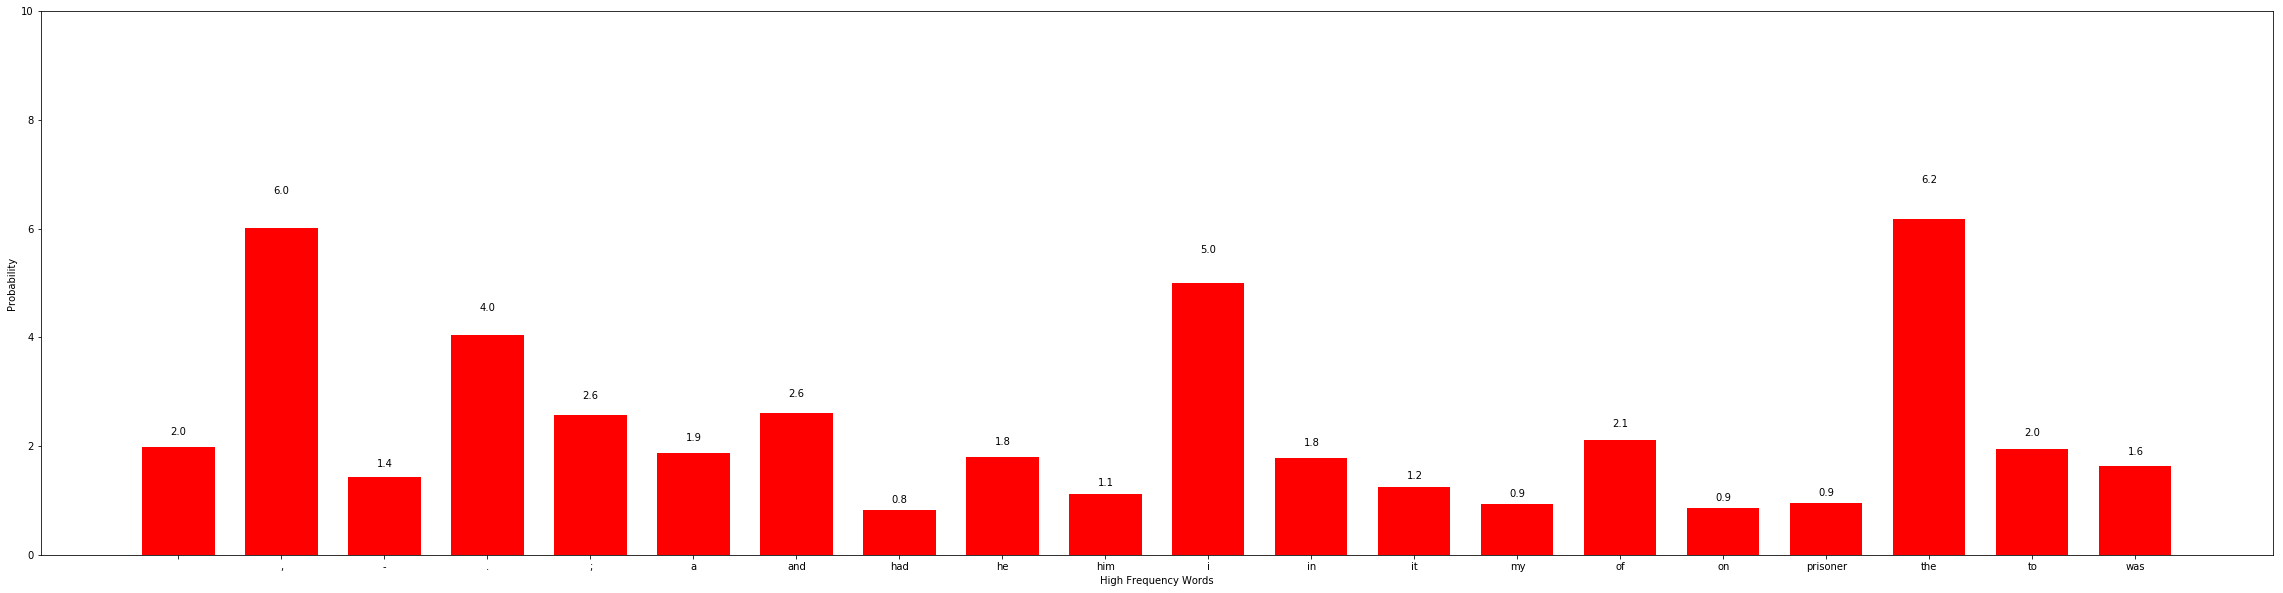

In [20]:
k=100000
hfperiods_theft=find_hfw_dist([p1_corpus,p2_corpus,p3_corpus],k=k)
function_words_theft=display_list([hfperiods_theft],cutoff=20)

Size of corpus is 457201
Size of corpus is 645170
Size of corpus is 335577


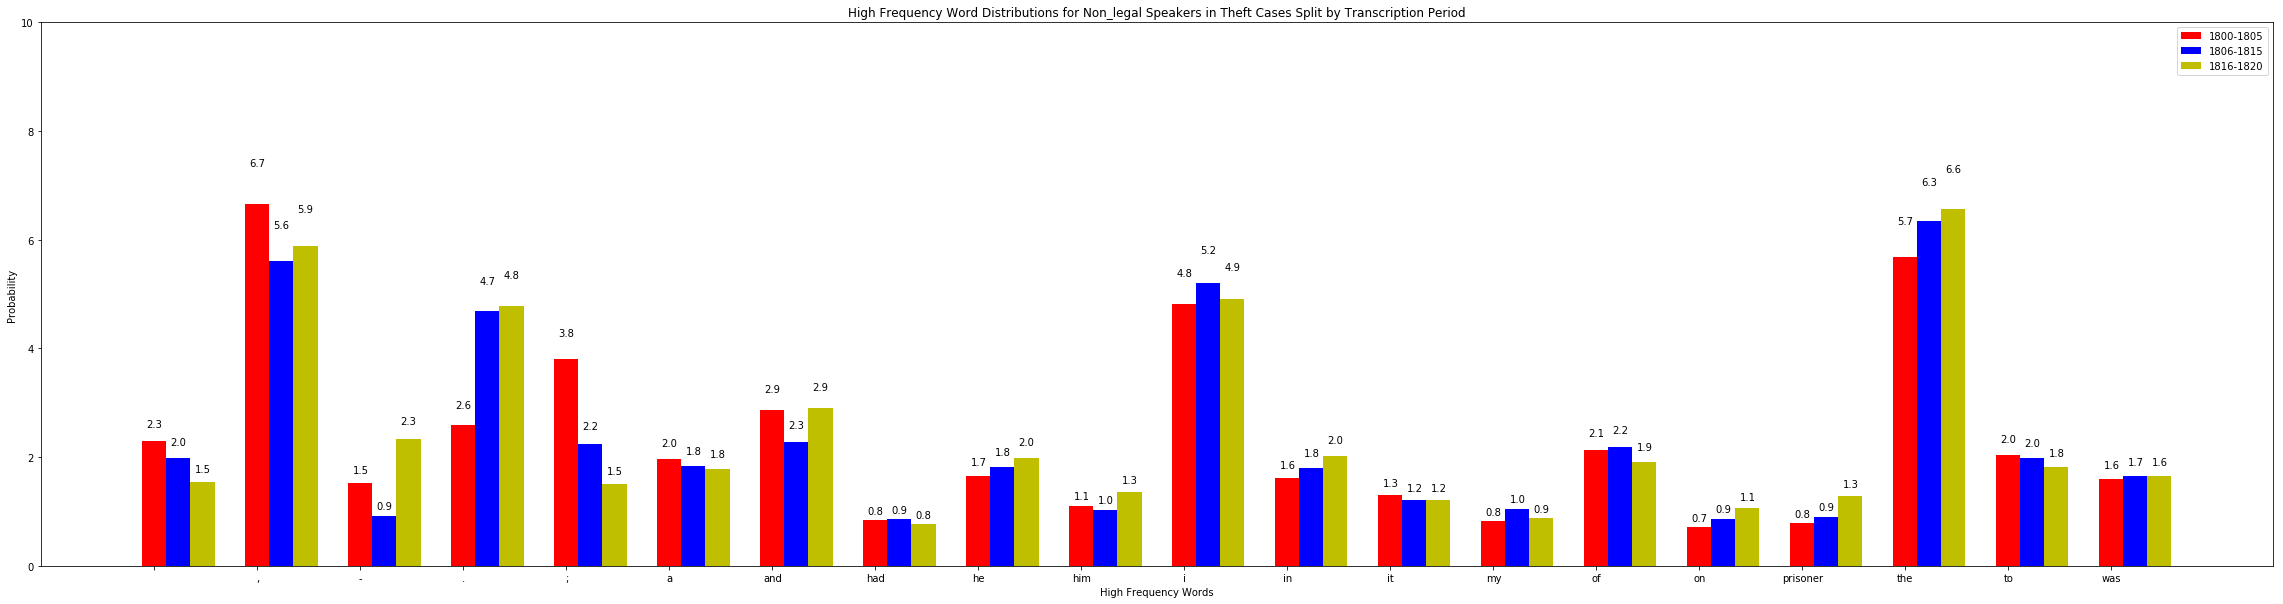

In [21]:

hfp1_theft=find_hfw_dist([p1_corpus],k=k)
hfp2_theft=find_hfw_dist([p2_corpus],k=k)
hfp3_theft=find_hfw_dist([p3_corpus],k=k)
some_words=display_list([hfp1_theft,hfp2_theft,hfp3_theft],words=function_words_theft,leg=['1800-1805','1806-1815','1816-1820'],title="High Frequency Word Distributions for Non_legal Speakers in Theft Cases Split by Transcription Period")

Comparing the different corpora, we see that there is a much greater use of ; in the first period and correspondingly, a greater use of . in the later periods.  We also see an increasing use of 'the' throughout the 3 periods and a corresponding decreasing use of 'a'.

In [22]:
p1words=improved_compute_surprises(hfp1_theft,hfperiods_theft,'llr')

Top 50 terms are 
[(';', 3736.4459269388681), (':', 1458.3110734165061), (')', 535.47959448109157), ('produces', 530.32124722672199), ('yes', 515.21522455675699), ('upon', 496.84528575502861), (',', 465.13217105454351), ('but', 426.45499019329975), ('(', 423.54348473500437), ('\n', 322.17064959274239), ('no', 258.00405378714368), ('and', 163.73581618256003), ('can', 158.97184658715787), ('very', 142.91152194763004), ('identified', 130.08427272509815), ('then', 124.25862856385481), ("n't", 120.89555955690639), ('till', 118.54000666498337), ('warehouses', 93.409897803113921), ('say', 89.595204090119978), ('not', 81.4050756633834), ('mr.', 78.009115488388602), ('deposed', 77.917749486003274), ('letters', 73.68320582164344), ('aslett', 71.042653943120641), ('belonging', 61.802438445077328), ('lying', 61.613630307425815), ('jennings', 59.584161371649564), ('or', 58.41762074071454), ('guinea', 57.534001655679816), ('broke', 56.440430401385626), ('bar', 55.941445826758894), ('same', 51.649922

In [23]:
p2words=improved_compute_surprises(hfp2_theft,hfperiods_theft,'llr')

Top 50 terms are 
[('.', 1188.2542208353316), ('that', 595.63791351958457), ('this', 361.16105063123439), ('watchhouse', 361.04109272201583), ('shillings', 325.25121290530706), ('pound', 323.71231016977401), ('these', 232.74063307056878), ('is', 186.85639452039993), ('until', 150.56950296369607), ('my', 145.97370780803021), ('skins', 145.01423064631334), ('are', 140.78725933345993), ('march', 109.3731415084502), ('..', 93.444239496933136), ('produce', 92.842213932836671), ('22nd', 86.199168500444273), ('i', 82.815135019869103), ('catched', 80.24963560620354), ('pounds', 80.171227216870506), ('they', 77.863989237244141), ('she', 76.3577474730007), ('2nd', 69.617574747120486), ('pawned', 67.43958886237742), ('all', 62.669575075207717), ('pence', 57.618724291540914), ('ratcliffe', 57.459119144001207), ('woman', 57.192554783466591), ('pieces', 56.989980272720942), ('halfpence', 55.110347114912358), ('throwed', 54.499179926583466), ('3rd', 51.787412309749499), ('shop', 49.114676209197683), 

In [24]:
p3words=improved_compute_surprises(hfp3_theft,hfperiods_theft,'llr')

Top 50 terms are 
[('-', 2218.0077723870936), ('"', 897.47385030298506), ("o'clock", 571.71368170996516), ('.', 560.14901117095906), ('prisoner', 472.59994468538116), ('who', 429.13253345921351), ('secured', 393.84235088512639), ('live', 341.30685631712868), ('lives', 337.4935415771248), ('am', 335.49799739583023), ('?', 327.67370675460268), ('1l', 292.29101157895519), ('on', 202.67414144859981), ('pledged', 200.74821570966822), ('!', 198.11085779105562), ('him', 197.28599797597803), ('found', 186.73164560047496), ('july', 181.08350651068807), ('stated', 176.87225265908256), ('6d', 176.71512203767855), ('about', 168.59043575793567), ('ran', 160.15444276203664), ('which', 159.22046451565245), ('and', 140.92894519343963), ('s.', 129.48534416747788), ('august', 129.1025762556294), ('in', 127.10125684766263), ('prosecutor', 123.18297272962218), ('3s', 116.36568345384748), ('5l', 103.45699293677632), ('missed', 101.96463330007248), ('the', 99.76374786791348), ('l.', 88.742444693686338), ('n

## Analysis of Characterising Terms

Having derived a set of characterising terms for a subcorpus, we want to analyse them.  Basic analysis includes average frequency and POS tag distribution.  Further analysis includes clustering semantically.



In [25]:
def autolabel(rects,ax):
    """
    Attach a text label above each bar displaying its height
    """
    
    for rect in rects:
        height = rect.get_height()

        ax.text(rect.get_x() + rect.get_width()/2., height*1.1,
                '%1.1f' % height,
                ha='center', va='bottom')
        
def improved_display_list(xvalues,yvalueslist,labels={}):
    width=0.7/len(yvalueslist)      
    N=len(xvalues)
    ind=np.arange(N)
    fig,ax=plt.subplots(figsize=(20,12))
    rectset=[]
    colors=['r','b','y','g']
    for i,ps in enumerate(yvalueslist):
        rectset.append(ax.bar(ind+i*width,ps,width,color=colors[i]))
    
    leg=labels.get('leg',None)
    title=labels.get('title',None)
    xlabel=labels.get('xlabel','Year')
    ylabel=labels.get('ylabel','Probability')
    ylim=labels.get('ylim',1)
    if leg!=None:
        ax.legend(rectset,leg)
    ax.set_xticks(ind)
    ax.set_xticklabels(xvalues)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(0,ylim)
    for rects in rectset:
        autolabel(rects,ax)
    if title!=None:
        ax.set_title(title)
    plt.show()

In [26]:
#We have a corpus e.g., male_corpus and a set of characterising terms for that corpus e.g., malewords
def find_pos(term,corpus):
    pospos=['NOUN','VERB','ADJ','ADV','PUNCT','PROPN']
    counts={}
    for apos in pospos:
        counts[apos]=corpus.wordposdict.get((term,apos),0)
    
    total=sum(counts.values())
    
    gt=corpus.allworddict.get(term,0)
    counts['OTHER']=gt-total
    #print(term,gt,counts)
    if gt>0:
        poses=[(tag,weight/gt) for (tag,weight) in counts.items()]
    else:
        poses=[]
    #print(term,poses)
    return poses
    
def analyse(termset,corpus):
    freqs=[]
    somefreqs=[]
    posdict={}
    someposdict={}
    threshold=20
    for i,(term,relevance) in enumerate(termset):
        freq=corpus.allworddict[term]
        freqs.append(freq)
        if i<threshold:
            somefreqs.append(freq)
        poses=find_pos(term,corpus)
        for mypos,weight in poses:
            posdict[mypos]=posdict.get(mypos,0)+weight
            if i<threshold:
                someposdict[mypos]=someposdict.get(mypos,0)+weight
            
        
    freqarray=np.array(freqs)    
    meanfreq=np.mean(freqarray)
    sdfreq=np.std(freqarray)
    meanprob=meanfreq/corpus.wordtotal
    sdprob=sdfreq/corpus.wordtotal
    print("Mean frequency is {}, sd is {}".format(meanfreq,sdfreq))
    print("Mean probability is {}, sd is {}".format(meanprob,sdprob))
    somefreqarray=np.array(somefreqs)
    meansomefreq=np.mean(somefreqarray)
    sdsomefreq=np.std(somefreqarray)
    meansomeprob=meansomefreq/corpus.wordtotal
    sdsomeprob=sdsomefreq/corpus.wordtotal
    print("For top {} words, mean freq is {}, sd is {}".format(threshold,meansomefreq,sdsomefreq))
    print("For top {} words, mean prob is {}, sd is {}".format(threshold,meansomeprob,sdsomeprob))
    #print(posdict)
    xvalues=posdict.keys()
    totaly=sum(posdict.values())
    totalz=sum(someposdict.values())
    allvalues=[]
    somevalues=[]
    for x in xvalues:
        allvalues.append(posdict.get(x,0))
        somevalues.append(someposdict.get(x,0))
    yvalues=[[100*y/totaly for y in allvalues],[100*z/totalz for z in somevalues]]
    labels={'title':'Distribution of POS in Characterising Terms','xlabel':'Part of Speech','ylabel':'Proportion','leg':['Whole Set',"Top {}-restricted Set".format(threshold)],'ylim':100}
    improved_display_list(xvalues,yvalues,labels)

Mean frequency is 1494.8835341365461, sd is 6578.963647962712
Mean probability is 0.0010395949882308303, sd is 0.0045752444789121105
For top 20 words, mean freq is 4346.0, sd is 6293.400034957257
For top 20 words, mean prob is 0.0030223624220069153, sd is 0.004376653422068988


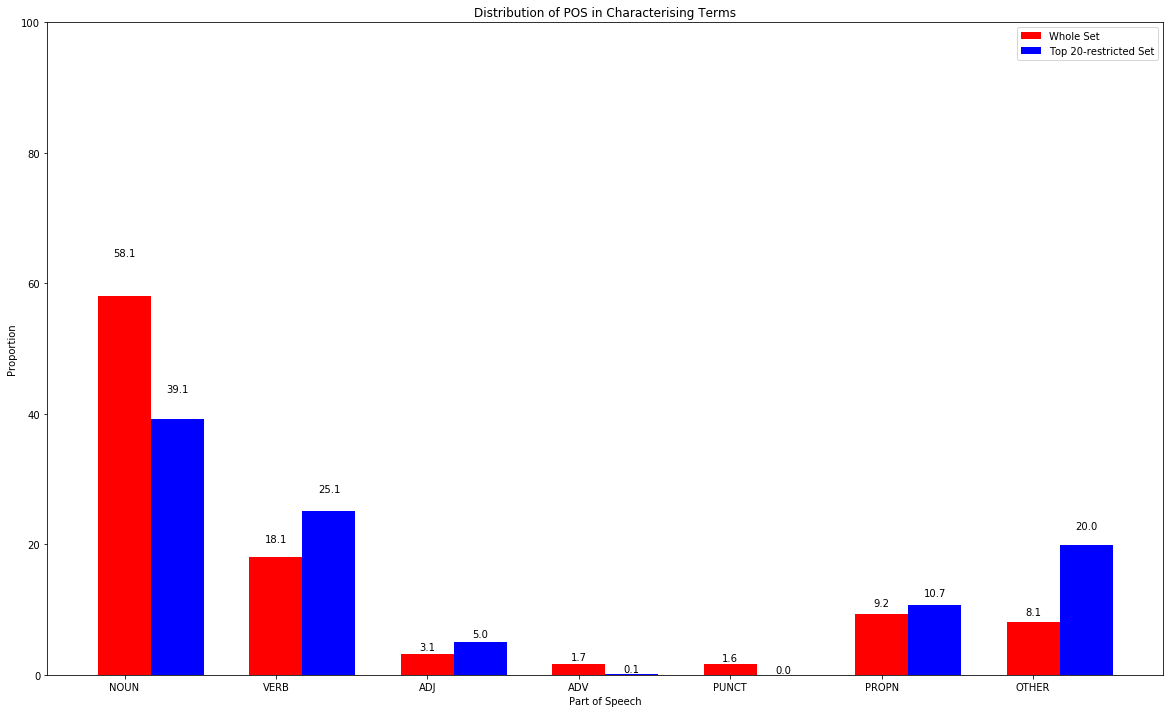

In [27]:
analyse(malewords,theft_corpus)

Mean frequency is 1115.9570815450643, sd is 3498.7043264361796
Mean probability is 0.0007760761039655567, sd is 0.0024331229824974057
For top 20 words, mean freq is 2177.15, sd is 3284.9888473935493
For top 20 words, mean prob is 0.0015140672680792353, sd is 0.0022844976643060454


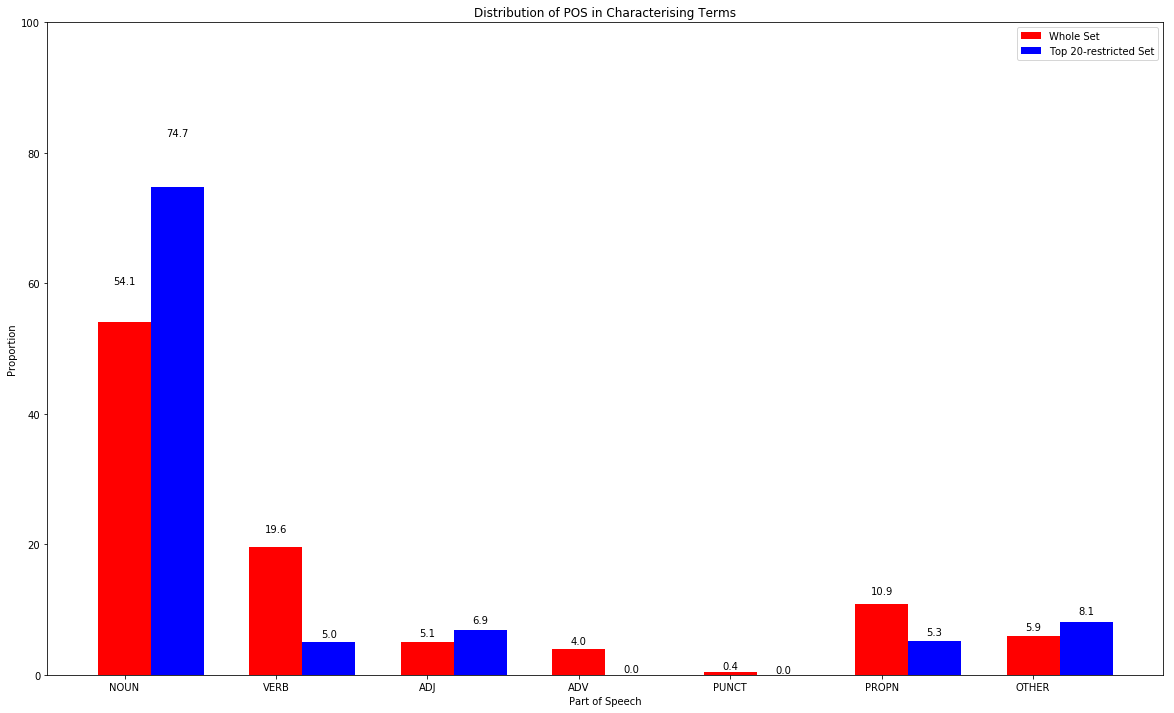

In [28]:
analyse(femalewords,theft_corpus)

Mean frequency is 1228.8291139240507, sd is 6453.708184077455
Mean probability is 0.0008545713154606778, sd is 0.004488137390279381
For top 20 words, mean freq is 10741.85, sd is 20985.234783711614
For top 20 words, mean prob is 0.007470263180587893, sd is 0.014593875984188312


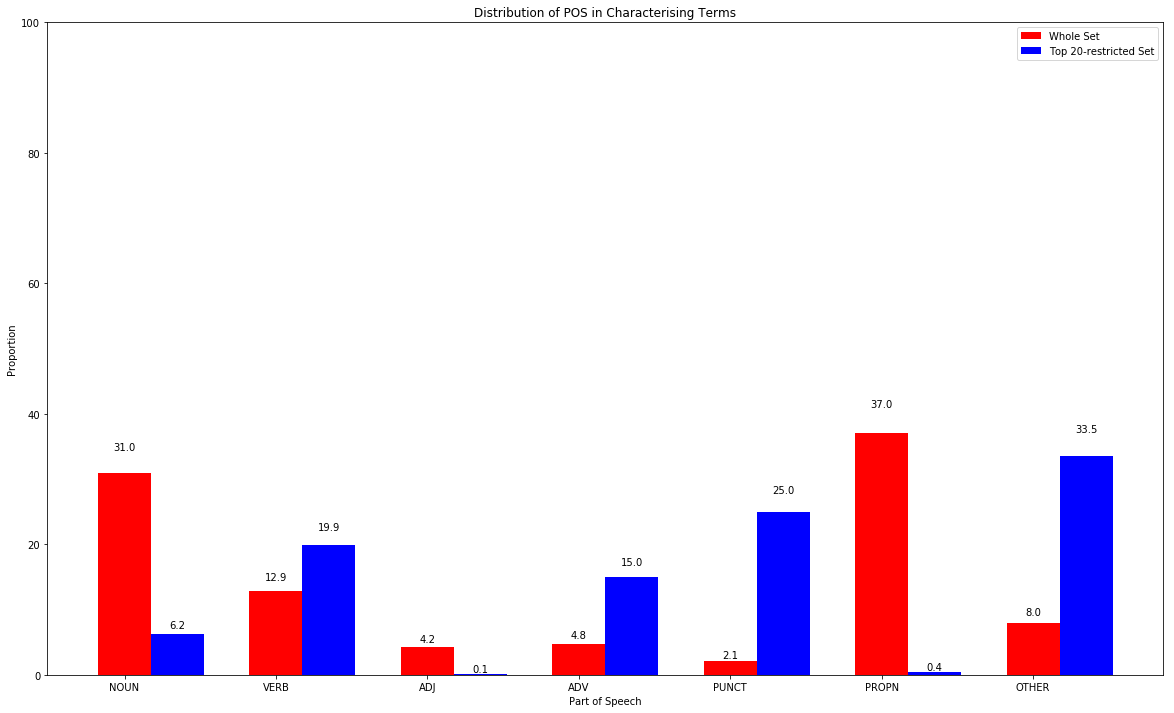

In [29]:
analyse(p1words,theft_corpus)

Mean frequency is 1343.5454545454545, sd is 7551.381061087571
Mean probability is 0.0009343491242697612, sd is 0.005251498010420106
For top 20 words, mean freq is 8691.15, sd is 19224.024917469807
For top 20 words, mean prob is 0.006044133723889876, sd is 0.013369068226020556


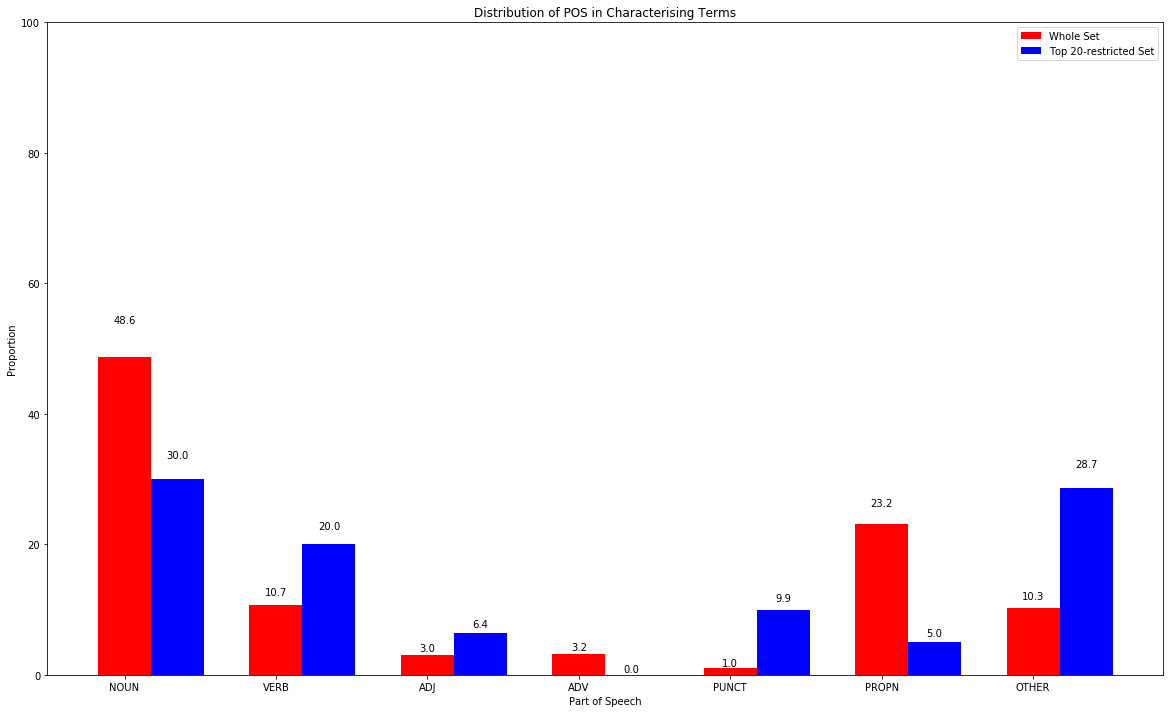

In [30]:
analyse(p2words,theft_corpus)

Mean frequency is 1142.0074074074073, sd is 6129.372850720945
Mean probability is 0.0007941924237923814, sd is 0.004262583105036444
For top 20 words, mean freq is 7270.6, sd is 13167.25150667367
For top 20 words, mean prob is 0.005056232909674063, sd is 0.00915697334442808


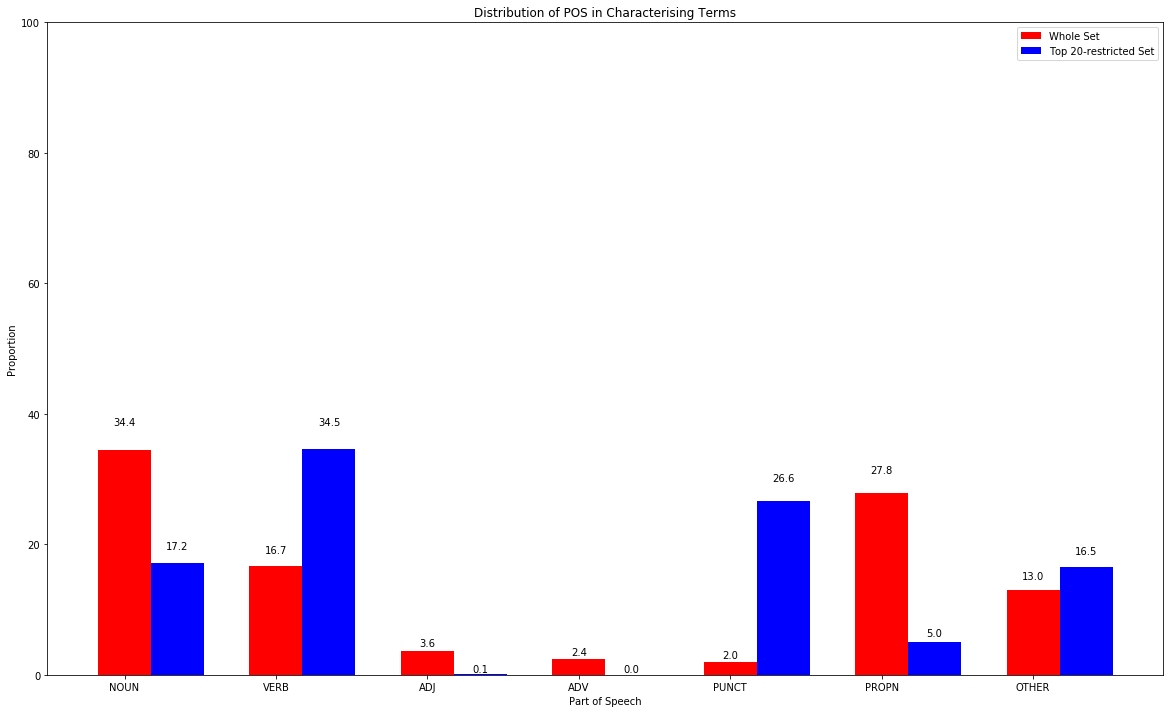

In [31]:
analyse(p3words,theft_corpus)

We can see that a much higher percentage of the characteristic words in the period corpora are proper nouns, punctuation and function words.  In the male/female splits, a higher percentage of the characteristic words are content words.  Looking at the most characterising words, it seems that there may be more characteristic nouns for females and more characteristic verbs for males but this would need further exploration.

## Word2Vec clustering


In [32]:
#from gensim.models import Word2Vec

#parameters
size=300
min_count=3
window=1
sg=1 #1=use skip-gram, otherwise=cbow

In [33]:
start=time.time()
theft_model=Word2Vec(theft_corpus.sentences,min_count=min_count,window=window,size=size,sg=sg,workers=4)
vocab=list(theft_model.wv.vocab.keys())
print("Word2Vec model built with example vocabulary:")
print(str(vocab[0:10]))
end=time.time()
print("Time taken: {}s".format(str(end-start)))

Word2Vec model built with example vocabulary:
['i', 'never', 'saw', 'the', 'woman', 'in', 'my', 'life', '.', '\n']
Time taken: 5.178601026535034s


In [34]:
theft_model.wv.most_similar(['.'])

[('..', 0.7322384715080261),
 ('?', 0.6475991606712341),
 ('....', 0.6310309171676636),
 ('\n', 0.5987094044685364),
 ('a.', 0.5092663168907166),
 ('is.\\', 0.5020322799682617),
 ('girdler', 0.49818021059036255),
 ('me.\\', 0.48205095529556274),
 ('tender', 0.47067442536354065),
 ('handcuffed', 0.46811094880104065)]

In [35]:
theft_model.wv.most_similar(['prisoner'])

[('defendant', 0.6969608068466187),
 ('prosecutrix', 0.67734295129776),
 ('prosecutor', 0.6728883981704712),
 ('landlord', 0.654723048210144),
 ('bar', 0.6493732929229736),
 ('lad', 0.6350243091583252),
 ('gentleman', 0.6308979988098145),
 ('bligh', 0.623530387878418),
 ('landlady', 0.6227681636810303),
 ('him', 0.6215431690216064)]

In [36]:
theft_model.wv.most_similar(['warehouse'])

[('stable', 0.8255642056465149),
 ('pantry', 0.8128893971443176),
 ('parlour', 0.7959429025650024),
 ('loft', 0.7909842729568481),
 ('stables', 0.7882765531539917),
 ('passage', 0.7836079597473145),
 ('garret', 0.7751137614250183),
 ('larder', 0.7731218338012695),
 ('cellar', 0.7721284031867981),
 ('workshop', 0.771009087562561)]

In [37]:
theft_model.wv.most_similar(['husband'])

[('mother', 0.8377269506454468),
 ('mistress', 0.8354591131210327),
 ('father', 0.834953784942627),
 ('daughter', 0.8232600092887878),
 ('sister', 0.8224149346351624),
 ('aunt', 0.7958475947380066),
 ('son', 0.7748600840568542),
 ('uncle', 0.7492965459823608),
 ('master', 0.7427887916564941),
 ('landlady', 0.7426922917366028)]

In [38]:
theft_model.wv.most_similar(['anne'])

[('mansell', 0.9484520554542542),
 ('181', 0.9474325180053711),
 ('spade', 0.9422292709350586),
 ('frisby', 0.942121148109436),
 ('lazarus', 0.9407080411911011),
 ('peacock', 0.9403005838394165),
 ('250', 0.9402751922607422),
 ('tuck', 0.9385563135147095),
 ('courtney', 0.9376021027565002),
 ('heywood', 0.9368712306022644)]

In [39]:
def nearest_neighbours(wordset,w2vmodel):
    threshold=20
    found=0
    for i,(term,score) in enumerate(wordset):
        try:
            neighbours=w2vmodel.wv.most_similar([term])
            found+=1
            if i<threshold:
                print(term,neighbours)
        except:
            print("{} not in vocab".format(term))
    
    oov=100-(found*100/len(wordset))
    print("Out of vocabulary: {}".format(oov))
    
    

In [40]:
nearest_neighbours(femalewords,theft_model)

she [('he', 0.7910948991775513), ('apparently', 0.6272772550582886), ('husband', 0.6238579750061035), ('bligh', 0.6203866004943848), ('drewee', 0.6185359954833984), ('strongly', 0.6178049445152283), ('defendant', 0.6090409755706787), ('they', 0.6010313034057617), ('provided', 0.60035240650177), ('moody', 0.5967408418655396)]
husband [('mother', 0.8377269506454468), ('mistress', 0.8354591131210327), ('father', 0.834953784942627), ('daughter', 0.8232600092887878), ('sister', 0.8224149346351624), ('aunt', 0.7958475947380066), ('son', 0.7748600840568542), ('uncle', 0.7492965459823608), ('master', 0.7427887916564941), ('landlady', 0.7426922917366028)]
her [('him', 0.6722577810287476), ('herself', 0.6457404494285583), ('me', 0.5861806869506836), ('refused', 0.5779205560684204), ('us', 0.5725857615470886), ('necessary', 0.5626729726791382), ('prisoners', 0.5615514516830444), ('voluntarily', 0.5542905926704407), ('stove', 0.5507855415344238), ('langley', 0.5465488433837891)]
room [('kitchen', 

In [41]:
nearest_neighbours(malewords,theft_model)

him [('me', 0.7622953653335571), ('us', 0.7150976657867432), ('her', 0.6722577810287476), ('langley', 0.6402808427810669), ('bligh', 0.6285833120346069), ('drewee', 0.6272294521331787), ('waggoner', 0.6269999146461487), ('prisoner', 0.6215431690216064), ('resisted', 0.620693564414978), ('necessary', 0.6188138723373413)]
his [('their', 0.7271846532821655), ('your', 0.7087836265563965), ('my', 0.640023946762085), ('its', 0.5770837068557739), ('our', 0.5584834218025208), ('prisoners', 0.5581868886947632), ('creeping', 0.5554159283638), ('hid', 0.5487508177757263), ('lid', 0.5386791229248047), ('manages', 0.5359585285186768)]
he [('she', 0.7910948991775513), ('bligh', 0.6894763708114624), ('drewee', 0.6805824041366577), ('defendant', 0.6783612370491028), ('apparently', 0.6693963408470154), ('holloa', 0.6495265364646912), ('resisted', 0.6483147740364075), ('tom', 0.6445602178573608), ('they', 0.6432110071182251), ('still', 0.6393678188323975)]
am [('journeyman', 0.5836947560310364), ('procu

In [42]:
nearest_neighbours(p1words,theft_model)

; [(':', 0.6900843381881714), (',', 0.6617554426193237), ('calls', 0.617371141910553), ('untill', 0.5993716716766357), ('accordingly', 0.5946670770645142), ('bligh', 0.5910207033157349), ('accidentally', 0.5901991128921509), ('because', 0.5897072553634644), ('latterly', 0.5840656757354736), ('instantly', 0.5831595063209534)]
: [(';', 0.6900843381881714), (',', 0.5506141781806946), ('preceding', 0.515740156173706), ('friday', 0.512798547744751), ('following', 0.505316972732544), ('easter', 0.499714195728302), ('thursday', 0.48694247007369995), ('....', 0.4863901734352112), ("se'nnight", 0.48382386565208435), ('apprehended', 0.4805639386177063)]
) [('identified', 0.7190501689910889), ('producing', 0.7138635516166687), ('claimed', 0.6982994079589844), ('(', 0.6906498670578003), ('produces', 0.6586980819702148), ('repeating', 0.6485692262649536), ('produced', 0.6476848125457764), ('reads', 0.6321386098861694), ('read', 0.6234762668609619), ('redeemed', 0.6174880862236023)]
produces [('prod

In [43]:
nearest_neighbours(p2words,theft_model)

. [('..', 0.7322384715080261), ('?', 0.6475991606712341), ('....', 0.6310309171676636), ('\n', 0.5987094044685364), ('a.', 0.5092663168907166), ('is.\\', 0.5020322799682617), ('girdler', 0.49818021059036255), ('me.\\', 0.48205095529556274), ('tender', 0.47067442536354065), ('handcuffed', 0.46811094880104065)]
that [('which', 0.6125654578208923), ('most', 0.600506067276001), ('wrong', 0.5997452735900879), ('whom', 0.5938327312469482), ('because', 0.5793938636779785), ('strongly', 0.5777363777160645), ('hoped', 0.575642466545105), ('spent', 0.5746021270751953), ('dare', 0.5743037462234497), ('drummer', 0.5734630823135376)]
this [('the', 0.531758189201355), ('third', 0.5295563340187073), ('print', 0.5285505056381226), ('second', 0.5207878947257996), ('another', 0.5201473236083984), ('lace', 0.5177813172340393), ('duplicate', 0.515021026134491), ('butter', 0.5141327977180481), ('that', 0.5122814774513245), ('soap', 0.507900059223175)]
watchhouse [('compter', 0.9212020635604858), ('marlboro

In [44]:
nearest_neighbours(p3words,theft_model)

- [('square', 0.5205881595611572), ('lion', 0.5152355432510376), ('keeper', 0.5041686296463013), ('row', 0.4997365474700928), ('cow', 0.49454134702682495), ('tavern', 0.48783326148986816), ('red', 0.48644930124282837), ('upper', 0.48295843601226807), ('elms', 0.4828019440174103), ('cross', 0.4755578637123108)]
" [('certainly', 0.6906331777572632), ('it.\\', 0.6553051471710205), ('\\is', 0.6472282409667969), ("ma'am", 0.6462962627410889), ('fact', 0.640906035900116), ('fainted', 0.6349145770072937), ('forgiveness', 0.6318692564964294), ('thief!\\', 0.6308915615081787), ('noton', 0.6240137815475464), ('pardon', 0.6205753684043884)]
o'clock [('afternoon', 0.7406047582626343), ('forenoon', 0.7302877902984619), ('noon', 0.7010945081710815), ('evening', 0.6909239292144775), ('dials', 0.6863881349563599), ('awoke', 0.6823599338531494), ('dusk', 0.6748583912849426), ('early', 0.6727287173271179), ('yesterday', 0.6720055937767029), ('morning', 0.6671335697174072)]
. [('..', 0.7322384715080261),

In [45]:
theft_model.wv.similarity('man','woman')

0.86532656809077557

In [46]:
def make_matrix(wordset,model,threshold=0.5):
    
    matrix=[]
    
    for (termA,_score) in wordset:
        row=[]
        for(termB,_score) in wordset:
            try:
                sim=model.wv.similarity(termA,termB)
                if sim<threshold:
                    sim=0
            except:
                sim=0
            row.append(sim)
            
        matrix.append(row)
    return matrix

In [47]:
female_matrix=make_matrix(femalewords,theft_model)

In [48]:
import csv

punctdict={"\n":"_NEWLINE",";":"_SEMICOLON",":":"_COLON","\"":"_QUOTE","'s":"_GEN","-":"_HYPHEN","(":"_LEFTBRACKET",")":"_RIGHTBRACKET",",":"_COMMA",".":"_FULLSTOP","..":"_DOTDOT"}

def clean(term):
    
    #remove punctuation which will confuse Gephi
    cleanterm=punctdict.get(term,term)
    return cleanterm

def make_csv(wordset,model,filename,threshold=0.5):
    matrix=make_matrix(wordset,model,threshold=threshold)
    terms=[clean(term) for (term,score) in wordset]
    
    #with open(filename,'w') as csvfile:
    #    csvwriter=csv.writer(csvfile,dialect='excel')
    #    headings=['']+terms
        #print(headings)
    #    csvwriter.writerow(headings)
    #    for term,row in zip(terms,matrix):
    #        csvwriter.writerow([term]+row)
     
    with open(filename,'w') as csvfile:
        line=""
        for term in terms:
            line+=';'+term
        line+='\n'
        
        csvfile.write(line)
        #print(line)
        for term,row in zip(terms,matrix):
            line=term
            #print(row)
            for item in row:
                line+=';'+str(item)
                
            line+='\n'
            
            csvfile.write(line)
            #print(line) 
    

In [49]:
make_csv(femalewords,theft_model,'matrix_female.csv',threshold=0.6)

In [50]:
make_csv(malewords,theft_model,'matrix_male.csv',threshold=0.6)

In [51]:
make_csv(p1words,theft_model,'matrix_p1.csv',threshold=0.6)

In [52]:
make_csv(p2words,theft_model,'matrix_p2.csv',threshold=0.6)

In [53]:
make_csv(p3words,theft_model,'matrix_p3.csv',threshold=0.6)

In [54]:
print(malewords)

[('him', 442.41345870034957), ('his', 247.77749750521707), ('he', 206.13168490977932), ('am', 120.27857259305301), ('horse', 119.3751563997788), ('officer', 108.64030115681004), ('mr.', 101.06793804018218), ('custody', 97.285799304172585), ('produce', 87.890490623532742), ('constable', 86.154282250474409), ('warehouse', 80.68591129094581), ('searched', 76.681281301105855), ('from', 73.52285795469777), ('by', 72.40681987038954), ('apprehended', 68.346152231433365), ('messrs.', 68.009932678737769), ('charge', 67.197441891234945), ('office', 66.954402580793769), ('sheep', 64.313009188703461), ('took', 63.204389881960196), ('clerk', 61.807390502893426), ('of', 60.210455319237667), ('watch', 60.043153234982867), ('lead', 58.189767627411406), ('pigs', 56.01888518387976), ('book', 54.584336398890741), ('yards', 54.134900868249801), ('pocket', 53.195395622472148), ('bag', 50.785337882316227), ('stable', 49.650122040041637), ('watchman', 48.160023550359398), ('hundred', 47.395880821068005), ('f

In [55]:
theft_lexicon=makedict(hfperiods_theft[1])
p1theft_lexicon=makedict(hfp1_theft[1])

In [56]:
def lookup(term,d1,d2):
    lex1=makedict(d1[1])
    lex2=makedict(d2[1])
    print('{}:{},{}'.format(term,lex1[term],lex2[term]))

In [57]:
lookup('fork',hfperiods_theft,hfp1_theft)

fork:15,12


In [58]:
lookup('drawer',hfw_theft,hff_theft)

drawer:244,89


## Random Corpora
I have generated a random split of the corpora with the same size characteristics as the female-male split (18% female).  The idea is to generate characteristic words from these - and then examine them in the same way as the female-male split.  How many supposedly characteristic words are there?  How do they cluster semantically?  It will be useful to do this for a 3 way random period split as well.

In [59]:
random_female=['randomA_18__theft_min:1800_max:1820_def_wv']
random_male=['randomB_18__theft_min:1800_max:1820_def_wv']

random_female_corpus=nlp_tools.corpus(random_female,nlp,prop=100,ner=False)
random_male_corpus=nlp_tools.corpus(random_male,nlp,prop=100,ner=False)


Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 512
Completed 512 docs (10.001953506544247% complete)
Completed 1024 docs (20.003907013088494% complete)
Completed 1536 docs (30.00586051963274% complete)
Completed 2048 docs (40.00781402617699% complete)
Completed 2560 docs (50.009767532721234% complete)
Completed 3072 docs (60.01172103926548% complete)
Completed 3584 docs (70.01367454580974% complete)
Completed 4096 docs (80.01562805235397% complete)
Completed 4608 docs (90.01758155889823% complete)
Number of documents is 5119
Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 2333
Completed 2333 docs (10.003001329160057% complete)
Completed 4666 docs (20.006002658320114% complete)
Completed 6999 docs (30.00900398748017% complete)
Completed 9332 docs (40.01200531664023% complete)
Completed 11665 docs (50.015006645800284% complete)
Completed 13998 docs (60.01800797496034% complete)
Completed 16331 docs (70.0210093041204% complete)
Complete

Size of corpus is 261971
Size of corpus is 1175977


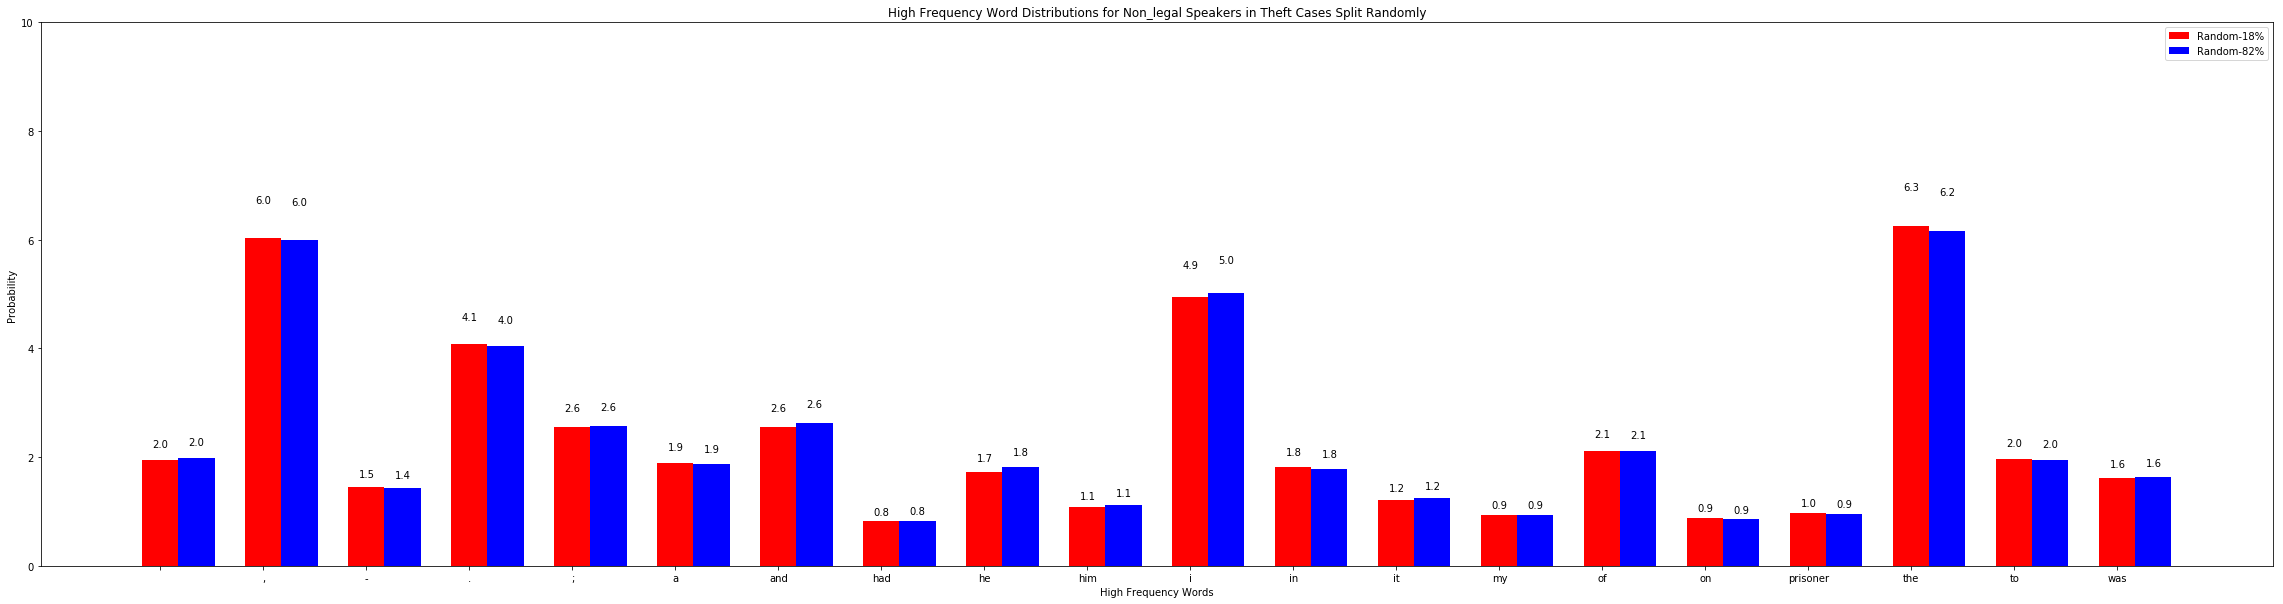

In [60]:
random_f_theft=find_hfw_dist([random_female_corpus],k=k)
random_m_theft=find_hfw_dist([random_male_corpus],k=k)
some_words=display_list([random_f_theft,random_m_theft],words=function_words_theft,leg=['Random-18%','Random-82%'],title="High Frequency Word Distributions for Non_legal Speakers in Theft Cases Split Randomly")

In [61]:
random_f_words=improved_compute_surprises(random_f_theft,hfw_theft,'llr')

Top 50 terms are 
[('pig', 28.640268794594935), ('jennings', 23.967198193204268), ('langley', 23.099756630309042), ('drover', 20.770461170262301), ('veal', 19.799791397407752), ('rev.', 17.244709882772955), ('cocoa', 16.499826164506459), ('despencer', 16.499826164506459), ('atkinson', 16.499826164506459), ('stall', 15.42807704959853), ('sewing', 15.357474063775499), ('separated', 14.788318996021779), ('shoes', 14.083822078316501), ('sows', 13.583094609093276), ('mahony', 13.199860931605167), ('hains', 13.199860931605167), ('shuter', 13.199860931605167), ('1806', 13.199860931605167), ('quarterns', 13.199860931605167), ('mantua', 13.199860931605167), ('terrible', 13.199860931605167), ('sins', 13.199860931605167), ('quicksets', 13.199860931605167), ('virgin', 13.199860931605167), ('head', 13.129853768218297), ('boxes', 12.743549891460141), ('mr', 12.64044640026003), ('latch', 12.206272717627659), ('o', 12.162025324700739), ('mansfield', 11.655465573833194), ('plumb', 11.519609903273992), 

/Users/juliewe/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


In [62]:
random_m_words=improved_compute_surprises(random_m_theft,hfw_theft,'llr')

Top 50 terms are 
[('-', 142.97120276156465), ('coach', 57.160295767769739), ('examined', 53.67758469215628), ('bill', 39.178436752989242), ("o'clock", 34.535650274203306), ('september', 31.892024462577105), ('prosecutrix', 30.512732161640457), ('mercy', 27.735556061947683), ('money', 26.756296492182486), ('laid', 25.790605622595102), ('told', 25.10688373862908), ('returned', 23.7585292218658), ('oxford', 22.948549672970003), ('son', 22.877834710975787), ('asked', 22.520907416566217), ('me', 20.063855331660989), ('would', 19.441109777001145), ('he', 18.414869931565818), ('9th', 16.495590553565556), ('ship', 15.57752018545645), ('got', 15.433458228510972), ('copper', 15.279315715475903), ('carry', 14.879577196854026), ('holborn', 14.686994008756059), ('him', 14.155949422038191), ('i', 13.926923050762639), ('for', 13.686450113540189), ('said', 12.94050812385413), ('others', 12.794931321585057), ('them', 12.531321942432186), ('am', 11.732961449609519), ('found', 11.491263407201529), ('bre

/Users/juliewe/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


In [63]:
femalefile='random_f_words_llr'
malefile='random_m_words_llr'
with open(femalefile,'w') as femstream:
    for (term,score) in random_f_words:
        femstream.write("{}\t{}\n".format(term,score))
        
with open(malefile,'w') as manstream:
    for(term,score) in random_m_words:
        manstream.write("{}\t{}\n".format(term,score))

In [64]:
nearest_neighbours(random_f_words,theft_model)

pig [('ham', 0.8725151419639587), ('plane', 0.8664980530738831), ('chisel', 0.8643568158149719), ('truck', 0.8557862043380737), ('poker', 0.8533236384391785), ('pistol', 0.8517941236495972), ('stool', 0.8484199643135071), ('sack', 0.8453943729400635), ('goose', 0.8437058925628662), ('stove', 0.8432003259658813)]
jennings [('guy', 0.9389244318008423), ('cole', 0.938379168510437), ('spode', 0.9376243948936462), ('yerraway', 0.9371733665466309), ('cornish', 0.9348993301391602), ('drake', 0.9345240592956543), ('sewell', 0.9341208934783936), ('mullett', 0.932621419429779), ('nalder', 0.9320751428604126), ('tyler', 0.9319541454315186)]
langley [('decamp', 0.9025112390518188), ('conway', 0.9022970199584961), ('townsend', 0.9022689461708069), ('thorn', 0.9020599126815796), ('bookkeeper', 0.8972045183181763), ('leadbetter', 0.8970913887023926), ('dyson', 0.8947041630744934), ('copers', 0.893876850605011), ('nathan', 0.892416775226593), ('hose', 0.8908802270889282)]
drover [('blacksmith', 0.9014

In [65]:
nearest_neighbours(random_m_words,theft_model)

- [('square', 0.5205881595611572), ('lion', 0.5152355432510376), ('keeper', 0.5041686296463013), ('row', 0.4997365474700928), ('cow', 0.49454134702682495), ('tavern', 0.48783326148986816), ('red', 0.48644930124282837), ('upper', 0.48295843601226807), ('elms', 0.4828019440174103), ('cross', 0.4755578637123108)]
coach [('waggon', 0.7555973529815674), ('public', 0.7388674020767212), ('candle', 0.7376385927200317), ('stage', 0.7184765934944153), ('stable', 0.7161608934402466), ('lamp', 0.7126625180244446), ('counting', 0.7120590209960938), ('stove', 0.7002966403961182), ('serjeant', 0.6938216686248779), ('post', 0.6930097341537476)]
examined [('traced', 0.7316015958786011), ('compared', 0.7269797325134277), ('counted', 0.7067716717720032), ('redeemed', 0.6993709802627563), ('opened', 0.686062216758728), ('entered', 0.65254807472229), ('measured', 0.6519261598587036), ('rode', 0.6496441960334778), ('shook', 0.6430277824401855), ('unloaded', 0.6411580443382263)]
bill [('draft', 0.83005130290

In [66]:
random_m_words_kl=improved_compute_surprises(random_m_theft,hfw_theft,'kl')
random_f_words_kl=improved_compute_surprises(random_f_theft,hfw_theft,'kl')

Top 50 terms are 
[('-', 0.0018006761675183997), ('i', 0.0010410804741163215), ('he', 0.00072266588398803159), ('july', 0.00053823652027241596), ('me', 0.00050124663629613829), ('him', 0.00049850101365014616), ('and', 0.00042180836012239173), ("o'clock", 0.00036709179324719053), ('said', 0.00034270385679934027), ('it', 0.00033400018249736958), ('am', 0.00032952780172001967), ('for', 0.00032685162080992551), ('told', 0.00031354038933435215), ('them', 0.00029799019294837243), ('asked', 0.00029691645378593828), ('with', 0.00026859008444228924), ('august', 0.00026764764496313382), ('cart', 0.00025698816449993167), ('at', 0.00025668202690435303), ('found', 0.00025326110068900158), ('would', 0.00023928326177963748), ('got', 0.00021668462904516025), ('money', 0.00021351266445983553), ('about', 0.00019255968743063016), ('again', 0.00016733703095018647), ('coach', 0.0001624656992975046), ('examined', 0.00015786196095553311), ('fowls', 0.00014930369901483605), ('returned', 0.00014404184974356211

/Users/juliewe/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log


In [67]:
make_csv(random_f_words,theft_model,'random_f_matrix.csv',threshold=0.6)
make_csv(random_m_words,theft_model,'random_m_matrix.csv',threshold=0.6)

## Semantic Coherance of Characteristic Words
Lets look at how semantically coherant sets of characteristic words are.  
Method 1: Take top k characterist word neighbours of each characteristic word.  Compute average similarity.  This could be weighted by rank 

In [68]:
def find_topk(alist,k):
    #ignore top neighbour as this is the word itself
    
    sortedlist=sorted(alist,reverse=True)
    if sortedlist[1]==0:
        return []
    if k==-1:
        return(sortedlist[1:])
    else:
        return(sortedlist[1:k+1])

def semantic_coherance(word_set,model,k=1,verbose=True):
    matrix=make_matrix(word_set,model)
    #print(matrix)
    mysum=0
    total=0
    for row in matrix:
        topk=find_topk(row,k)
        mysum+=sum(topk)
        total+=len(topk)
    if total==0:
        average=0
    else:
        average=mysum/total
    if verbose:
        print("Average semantic coherance at k={}: {}".format(k,average))
    return average
    
def coherance_profile(words,model,verbose=True):
    scores=[]
    scores.append(semantic_coherance(words,model,k=1,verbose=verbose))
    scores.append(semantic_coherance(words,model,k=2,verbose=verbose))
    scores.append(semantic_coherance(words,model,k=5,verbose=verbose))
    scores.append(semantic_coherance(words,model,k=10,verbose=verbose))
    scores.append(semantic_coherance(words,model,k=-1,verbose=verbose))
    return scores
    

In [69]:
alist=[0.5,0.8,1,0.9,0,0,0.7]
find_topk(alist,2)

[0.9, 0.8]

In [70]:
coherance_profile(femalewords,theft_model)

Average semantic coherance at k=1: 0.8032977017051232
Average semantic coherance at k=2: 0.7841543133416518
Average semantic coherance at k=5: 0.7488346602091824
Average semantic coherance at k=10: 0.7122122496532011
Average semantic coherance at k=-1: 0.24160375797395967


[0.80329770170512316,
 0.78415431334165175,
 0.74883466020918243,
 0.71221224965320107,
 0.24160375797395967]

In [71]:
coherance_profile(random_f_words,theft_model)

Average semantic coherance at k=1: 0.8615174865650557
Average semantic coherance at k=2: 0.8519686628915544
Average semantic coherance at k=5: 0.8335557792382672
Average semantic coherance at k=10: 0.8113747060034506
Average semantic coherance at k=-1: 0.6693265154357758


[0.86151748656505567,
 0.85196866289155437,
 0.83355577923826718,
 0.81137470600345063,
 0.66932651543577582]

In [72]:
coherance_profile(malewords,theft_model)

Average semantic coherance at k=1: 0.7740582915407419
Average semantic coherance at k=2: 0.74835596974148
Average semantic coherance at k=5: 0.7076411238084952
Average semantic coherance at k=10: 0.6701474744495151
Average semantic coherance at k=-1: 0.1710101328342932


[0.77405829154074191,
 0.74835596974148,
 0.7076411238084952,
 0.67014747444951506,
 0.1710101328342932]

In [73]:
coherance_profile(random_m_words,theft_model)

Average semantic coherance at k=1: 0.6437422602980434
Average semantic coherance at k=2: 0.5711309653423688
Average semantic coherance at k=5: 0.3244756974752191
Average semantic coherance at k=10: 0.17216331783164673
Average semantic coherance at k=-1: 0.055536554139240885


[0.64374226029804338,
 0.57113096534236885,
 0.32447569747521909,
 0.17216331783164673,
 0.055536554139240885]

In [74]:
coherance_profile(p1words,theft_model)

Average semantic coherance at k=1: 0.8536443241644326
Average semantic coherance at k=2: 0.8396886812606212
Average semantic coherance at k=5: 0.8153217348035219
Average semantic coherance at k=10: 0.7934556069752356
Average semantic coherance at k=-1: 0.41853438184731384


[0.85364432416443259,
 0.83968868126062124,
 0.81532173480352188,
 0.79345560697523565,
 0.41853438184731384]

In [75]:
coherance_profile(p2words,theft_model)

Average semantic coherance at k=1: 0.826790725176748
Average semantic coherance at k=2: 0.8156549540293989
Average semantic coherance at k=5: 0.7872199417564355
Average semantic coherance at k=10: 0.7613287182398192
Average semantic coherance at k=-1: 0.31266556259511796


[0.82679072517674801,
 0.81565495402939892,
 0.7872199417564355,
 0.76132871823981918,
 0.31266556259511796]

In [76]:
coherance_profile(p3words,theft_model)

Average semantic coherance at k=1: 0.855985118960122
Average semantic coherance at k=2: 0.8395606394372044
Average semantic coherance at k=5: 0.8166584377703151
Average semantic coherance at k=10: 0.7952567038957467
Average semantic coherance at k=-1: 0.3486019320604949


[0.85598511896012197,
 0.83956063943720438,
 0.8166584377703151,
 0.79525670389574665,
 0.34860193206049489]

The high semantic coherance of the random_f_words demonstrates that this method of finding characteristic words is flawed.  Presumably, there is high coherance in this set because the characteristic words are skewed towards semantics bearing words which occur frequently within the same utterance.  The bootstrap method may overcome this because it requires the words to be distributed across different trials. The random_m_words behave better ... presumably because this is the bigger portion.  Should repeat with different proportions.

In [77]:
coherance_profile(femalewords_kl,theft_model)

Average semantic coherance at k=1: 0.6523702459729758
Average semantic coherance at k=2: 0.5669656575326097
Average semantic coherance at k=5: 0.4233291308981065
Average semantic coherance at k=10: 0.30181790361075883
Average semantic coherance at k=-1: 0.06813691594478498


[0.65237024597297577,
 0.56696565753260975,
 0.42332913089810648,
 0.30181790361075883,
 0.068136915944784979]

In [78]:
coherance_profile(random_f_words_kl,theft_model)

Average semantic coherance at k=1: 0.6477611964868109
Average semantic coherance at k=2: 0.4995442394868635
Average semantic coherance at k=5: 0.29379977300655413
Average semantic coherance at k=10: 0.16766365456006307
Average semantic coherance at k=-1: 0.03515309284507505


[0.64776119648681085,
 0.49954423948686349,
 0.29379977300655413,
 0.16766365456006307,
 0.035153092845075049]

In [79]:
coherance_profile(random_m_words_kl,theft_model)

Average semantic coherance at k=1: 0.6529652125738892
Average semantic coherance at k=2: 0.5870784039681789
Average semantic coherance at k=5: 0.37762461595078706
Average semantic coherance at k=10: 0.20629721608901738
Average semantic coherance at k=-1: 0.04210147267122804


[0.65296521257388918,
 0.5870784039681789,
 0.37762461595078706,
 0.20629721608901738,
 0.042101472671228039]

In [80]:
coherance_profile(malewords_kl,theft_model)

Average semantic coherance at k=1: 0.6485007814615765
Average semantic coherance at k=2: 0.577330263180873
Average semantic coherance at k=5: 0.43895937733239665
Average semantic coherance at k=10: 0.2703340536697505
Average semantic coherance at k=-1: 0.05517021503464296


[0.64850078146157653,
 0.57733026318087299,
 0.43895937733239665,
 0.2703340536697505,
 0.055170215034642957]

Coherance doesn't seem to distinguish random from not random either using partialKL as the measure of characterisation.

## More Random Corpora - Different Proportions


In [81]:

splits=[5,10,15,20,25,30,35,40,45,50]
prefixA='randomA_'
prefixB='randomB_'
suffix='__theft_min:1800_max:1820_def_wv'
randomfiles=[]
props=[]
for split in splits:
    randomfiles.append(prefixA+str(split)+suffix)
    props.append(split)
    rev=100-split
    props.append(rev)
    randomfiles.append(prefixB+str(split)+suffix)
print(randomfiles,props)

['randomA_5__theft_min:1800_max:1820_def_wv', 'randomB_5__theft_min:1800_max:1820_def_wv', 'randomA_10__theft_min:1800_max:1820_def_wv', 'randomB_10__theft_min:1800_max:1820_def_wv', 'randomA_15__theft_min:1800_max:1820_def_wv', 'randomB_15__theft_min:1800_max:1820_def_wv', 'randomA_20__theft_min:1800_max:1820_def_wv', 'randomB_20__theft_min:1800_max:1820_def_wv', 'randomA_25__theft_min:1800_max:1820_def_wv', 'randomB_25__theft_min:1800_max:1820_def_wv', 'randomA_30__theft_min:1800_max:1820_def_wv', 'randomB_30__theft_min:1800_max:1820_def_wv', 'randomA_35__theft_min:1800_max:1820_def_wv', 'randomB_35__theft_min:1800_max:1820_def_wv', 'randomA_40__theft_min:1800_max:1820_def_wv', 'randomB_40__theft_min:1800_max:1820_def_wv', 'randomA_45__theft_min:1800_max:1820_def_wv', 'randomB_45__theft_min:1800_max:1820_def_wv', 'randomA_50__theft_min:1800_max:1820_def_wv', 'randomB_50__theft_min:1800_max:1820_def_wv'] [5, 95, 10, 90, 15, 85, 20, 80, 25, 75, 30, 70, 35, 65, 40, 60, 45, 55, 50, 50]


In [82]:
randomcorpora=[]
for filename in randomfiles:
    print(filename)
    randomcorpora.append(nlp_tools.corpus([filename],nlp,prop=100,ner=False))

randomA_5__theft_min:1800_max:1820_def_wv
Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 143
Completed 143 docs (10.056258790436006% complete)
Completed 286 docs (20.112517580872012% complete)
Completed 429 docs (30.168776371308017% complete)
Completed 572 docs (40.225035161744024% complete)
Completed 715 docs (50.28129395218003% complete)
Completed 858 docs (60.33755274261603% complete)
Completed 1001 docs (70.39381153305204% complete)
Completed 1144 docs (80.45007032348805% complete)
Completed 1287 docs (90.50632911392405% complete)
Number of documents is 1422
randomB_5__theft_min:1800_max:1820_def_wv
Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 2703
Completed 2703 docs (10.003700962250186% complete)
Completed 5406 docs (20.00740192450037% complete)
Completed 8109 docs (30.011102886750557% complete)
Completed 10812 docs (40.01480384900074% complete)
Completed 13515 docs (50.01850481125093% complete)
Completed 16218 docs (60.0222

Completed 11094 docs (60.00649069666811% complete)
Completed 12943 docs (70.00757247944613% complete)
Completed 14792 docs (80.00865426222414% complete)
Completed 16641 docs (90.00973604500216% complete)
Number of documents is 18488
randomA_40__theft_min:1800_max:1820_def_wv
Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 1138
Completed 1138 docs (10.00351617440225% complete)
Completed 2276 docs (20.0070323488045% complete)
Completed 3414 docs (30.01054852320675% complete)
Completed 4552 docs (40.014064697609% complete)
Completed 5690 docs (50.01758087201125% complete)
Completed 6828 docs (60.0210970464135% complete)
Completed 7966 docs (70.02461322081575% complete)
Completed 9104 docs (80.028129395218% complete)
Completed 10242 docs (90.03164556962025% complete)
Number of documents is 11376
randomB_40__theft_min:1800_max:1820_def_wv
Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 1707
Completed 1707 docs (10.00234384155631% complete)

In [83]:
random_dists=[]
for corpus in randomcorpora:
    random_dists.append(find_hfw_dist([corpus],k=k))

characteristic_sets=[]
for dist in random_dists:
    characteristic_sets.append(improved_compute_surprises(dist,hfw_theft,'llr'))
sizes=[len(cset) for cset in characteristic_sets]

for p,s in zip(props,sizes):
    print("prop = {}, size of characteristic set = {}".format(p,s))

Size of corpus is 73253
Size of corpus is 1364695
Size of corpus is 149124
Size of corpus is 1288824
Size of corpus is 219560
Size of corpus is 1218388
Size of corpus is 298000
Size of corpus is 1139948
Size of corpus is 364727
Size of corpus is 1073221
Size of corpus is 433533
Size of corpus is 1004415
Size of corpus is 511554
Size of corpus is 926394
Size of corpus is 581588
Size of corpus is 856360
Size of corpus is 645043
Size of corpus is 792905
Size of corpus is 717143
Size of corpus is 720805
Top 50 terms are 
[('shenstone', 23.394377794981313), ('grains', 21.087990772219914), ('waggon', 20.989806660869359), ('soap', 19.139007900540857), ('stoney', 18.500749943942871), ('belt', 18.500749943942871), ('stary', 17.545783346235986), ('fish', 16.480509821500693), ('pence', 16.371166611442746), ('dines', 15.93201055424492), ('jones', 15.58598760414694), ('pint', 14.03095697667586), ('rope', 13.813318462679922), ('callico', 13.501813245979958), ('dr.', 13.448819558601386), ('brew', 13.

/Users/juliewe/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


Top 50 terms are 
[('the', nan), (',', nan), ('i', -717.55987690564098), ('.', nan), ('and', nan), (';', nan), ('of', nan), ('\n', nan), ('a', nan), ('he', nan), ('was', nan), ('bone', -5.64956399896049), ('it', -55.686862315007119), ('him', -184.60062585641219), ('in', -247.63982458349724), ('prisoner', -356.11464587557339), ('to', -475.02097951065173), ('-', -4551.9091704627936), ('my', nan), ('had', nan), ('not', nan), ('that', nan), ('with', -180.62326104558798), ('his', nan), ('went', nan), ('for', -182.70367107010702), ('her', -424.54082218801977), ("'s", nan), ('is', nan), ('mr.', nan), ('house', nan), ('no', nan), ('there', -0.15460069995919756), ('out', -25.007015802338973), ('on', -81.950172349575581), ('took', -148.14872013665391), ('at', -152.22581868182854), ('about', -276.65180644072359), ('she', -295.95994038132204), ('came', nan), ('up', nan), ('found', -184.10991467438535), ('saw', -270.90434840471301), ('said', -285.6717294871487), ('am', -373.81086343200309), ('them'

Top 50 terms are 
[('-', 123.96817793457069), ('cross', 68.919744287800185), ('sale', 30.885721520784791), ('me', 30.092813593514791), ('copper', 26.610505056934873), ('sacks', 25.48594710642611), ('boxes', 24.907635153992125), ('lace', 22.979731169827051), ('them', 21.304778582235912), ('discharged', 20.204651898928304), ('stated', 18.412823815624275), ('gave', 18.171773439035064), ('asked', 17.696091019130051), ('drove', 17.445717097764884), ('coach', 17.204986509571086), ('5l', 16.870979070451089), ('aged', 15.794108065954211), ('lane', 14.287949105573915), ('robbery', 14.036178155711195), ('shed', 13.969198940899556), ('stole', 13.232592243890121), ('said', 13.080253056492751), ('timber', 12.859974662018631), ('2l', 12.677581432732918), ('chaise', 12.272834632132597), ('tools', 12.202998733879086), ('halfpence', 11.628865646891459), ('agreed', 11.26469964677529), ('road', 11.158732792995863), ('inn', 11.004049768273656), ('alley', 10.986209473788755), ('money', 10.878112269135627),

Top 50 terms are 
[('july', 79.646358968580316), ('august', 37.44182985951619), ('fowls', 34.801656825271664), ('them', 32.619264070426198), ('-', 32.581811623887916), ('prosecutrix', 27.610928294248062), ('cross', 23.551411544470405), ('5l', 18.555809530579417), ('among', 18.394695065148596), ('examined', 18.041236753641023), ('sheets', 17.956624490452114), ('cart', 17.791602809375306), ('saffron', 17.362498457392558), ('desk', 16.620607248524166), ('leaving', 15.857107448991883), ('pail', 15.409179315160138), ('lace', 15.149285993531098), ('5s', 14.751328368732294), ('girls', 14.096942127589555), ('"', 13.88545238025857), ('september', 13.51799905858924), ('against', 12.886537983911744), ('lighter', 12.799437955057806), ('copy', 12.448347014504666), ('at', 12.344152581668368), ('evidence', 12.156810701749887), ('rosemary', 11.796961732208979), ('money', 11.70367691145546), ('pigs', 11.607442363055892), ('tools', 11.302153132633538), ('leave', 11.256765309387859), ('return', 10.889736

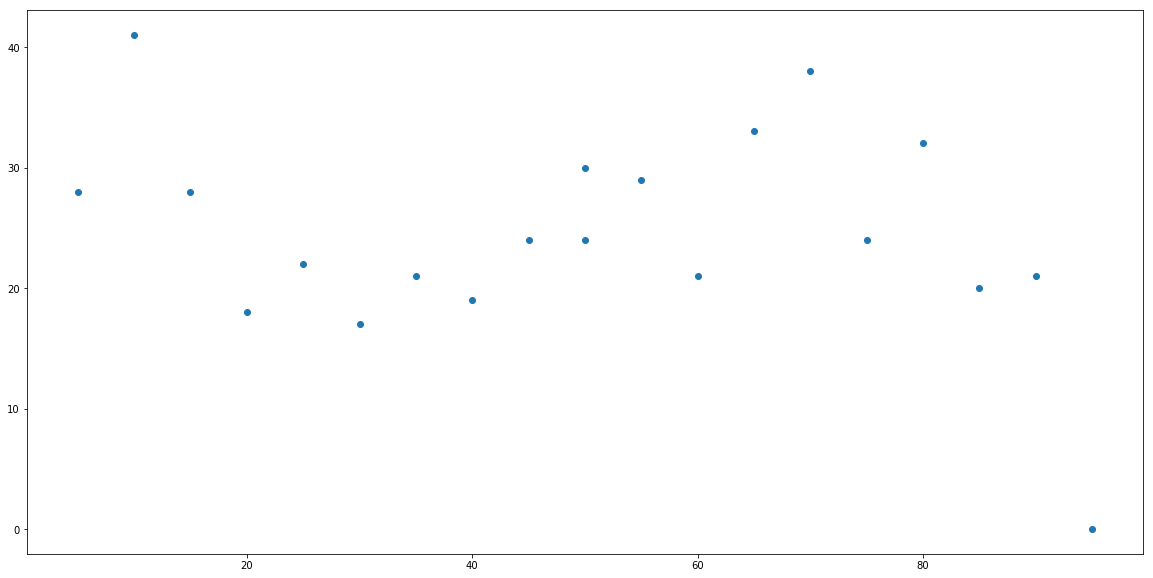

In [84]:
fig,ax=plt.subplots(figsize=(20,10))
ax.scatter(props,sizes)

In [85]:
jsd_characteristic_sets=[]
for dist in random_dists:
    jsd_characteristic_sets.append(improved_compute_surprises(dist,hfw_theft,'jsd'))
kl_characteristic_sets=[]
for dist in random_dists:
    kl_characteristic_sets.append(improved_compute_surprises(dist,hfw_theft,'kl'))

/Users/juliewe/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/Users/juliewe/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
/Users/juliewe/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log


Top 50 terms are 
[('waggon', 3.1065426284764955e-05), ('soap', 2.7777366967742142e-05), ('pence', 2.5735521521167984e-05), ('jones', 2.3403291750524861e-05), ('fish', 2.2718044060229317e-05), ('pint', 2.2103580718359035e-05), ('grains', 2.0476891780904589e-05), ('key', 1.9925646700445009e-05), ('waistcoat', 1.9802416627738559e-05), ('pot', 1.9341606648362773e-05), ('rope', 1.8629204568196442e-05), ('dr.', 1.7787461624583818e-05), ('dines', 1.745086032804843e-05), ('stoney', 1.7154795137726165e-05), ('belt', 1.7154795137726165e-05), ('coach', 1.710303113789796e-05), ('pound', 1.6649867157550867e-05), ('callico', 1.6592014832875145e-05), ('pots', 1.5456538892293876e-05), ('gibson', 1.513398794844525e-05), ('sewing', 1.513398794844525e-05), ('placed', 1.4780349987818289e-05), ('paul', 1.4452406943762213e-05), ('impossible', 1.4139201177587418e-05), ('wrote', 1.3531473328424879e-05), ('craig', 1.313867338618232e-05), ('eldridge', 1.313867338618232e-05), ('elderly', 1.2659567970043008e-05)

Top 50 terms are 
[('-', 0.00016493057109566434), ('work', 3.6304264672802091e-05), ('get', 1.9934955727390094e-05), ('shop', 1.8621632267587648e-05), ('i', 1.7765057935232339e-05), ('followed', 1.7325348500811767e-05), ('missed', 1.584984505221587e-05), ('am', 1.5451631571530464e-05), ('money', 1.4809827462767956e-05), ('charge', 1.46560723482879e-05), ('prosecutor', 1.3299043200887592e-05), ('ran', 1.151731887557989e-05), ('lane', 1.0374618089325889e-05), ('stopped', 1.0336766378694871e-05), ('live', 9.9678943718112652e-06), ('never', 9.9538688937456679e-06), ('took', 9.7649471406246883e-06), ('who', 9.7548762589736809e-06), ('it', 9.3362735777213833e-06), ('four', 9.1984924075556233e-06), ('hand', 9.1138283506955238e-06), ('bought', 8.9876108204072145e-06), ('paid', 8.7531115386950983e-06), ('our', 8.6191110453026664e-06), ('bag', 7.7603073576393129e-06), ('court', 7.4344701747338737e-06), ('seen', 7.4314949173838059e-06), ('pocket', 7.2666486694604389e-06), ('woman', 7.254207311157

Top 50 terms are 
[('july', 4.9305293357028424e-05), ('-', 4.4348514198849992e-05), ('august', 3.6029136761975154e-05), ('cross', 2.0798174161675089e-05), ('september', 1.33806143898897e-05), ('cart', 1.2466113505924636e-05), ('fish', 1.1628387340838475e-05), ('examined', 1.0899123962083415e-05), ('against', 9.6199680542064615e-06), ('miller', 9.3162289682187038e-06), ('pig', 9.2732567424191634e-06), ('sacks', 9.1552141141858943e-06), ('get', 8.9221551567169154e-06), ('6d', 8.7709789578993916e-06), ('attempted', 8.4127811259391573e-06), ('drawer', 8.0955321014688498e-06), ('us', 6.995615215475572e-06), ('named', 6.8777775468172192e-06), ('cheapside', 6.7327561052581541e-06), ('wall', 6.7277800148350406e-06), ('oats', 6.4563327588686746e-06), ('hart', 6.4338803808982648e-06), ('me', 6.2162664038723468e-06), ('found', 6.1031867300463617e-06), ('mutton', 6.02520572390301e-06), ('prosecutrix', 5.9945106760823173e-06), ('tottenham', 5.9895650304892316e-06), ('screw', 5.8445483253418578e-06)

Top 50 terms are 
[('august', 1.0675386744567654e-05), ('hay', 9.8286472479278596e-06), ('mr', 9.4812480918931827e-06), ('july', 9.2927778000956573e-06), ('-', 8.8051373668440768e-06), ('money', 7.9542990113563164e-06), ('cross', 6.953932611565576e-06), ('said', 6.9448276348841491e-06), ('crane', 6.8203646592039653e-06), ('me', 6.22375643865409e-06), ('20l', 6.1081763359992359e-06), ('examined', 6.0763020457871488e-06), ('would', 5.6392377051191699e-06), ('charge', 5.3490759632895992e-06), ('conduit', 5.348695385865637e-06), ('moon', 5.1992946181805181e-06), ('september', 5.0034070098362847e-06), ('stepped', 4.9678780770330498e-06), ('coach', 4.6746658079930484e-06), ('bought', 4.5939670105474916e-06), ('them', 4.5683562017171574e-06), ('mason', 4.5059976210451539e-06), ('nigh', 4.2780893332092298e-06), ('loaded', 4.2271135959406589e-06), ('reeve', 4.2048079669589745e-06), ("o'clock", 4.2023365913711197e-06), ('flat', 4.0290811314270007e-06), ('aldgate', 4.0290811314270007e-06), ('3s',

[('he', 0.00071908176793154029), ('to', 0.00037248988764253612), ('was', 0.00033249480682141157), ('door', 0.00027161311081685485), ('as', 0.00020448384510686208), ('asked', 0.0001975159989659588), ('.', 0.00019293979597813141), ('me', 0.00016763710080428221), ('house', 0.0001516918004784396), ('it', 0.00014719924014621952), ('we', 0.00014655350850921), ('were', 0.00013245914521267684), ('told', 0.00012571536207328543), ('parlour', 0.00012529582838269977), ('had', 0.00012381947619316755), ('open', 0.00011703359026031951), ('would', 0.00011687273090095937), ('brought', 0.00011649005365311405), ('delivered', 0.00011511098681883978), ('about', 0.00011187244846508824), ('said', 0.00010907532572070724), ('out', 0.00010811124520599286), ('never', 0.00010265927299814114), ('them', 0.0001017365227777758), ("o'clock", 9.7098100188266237e-05), ('key', 9.5816600492910759e-05), ('can', 9.5770054672795438e-05), ('parcel', 9.4197880822465631e-05), ('the', 9.0507704475114033e-05), ('-', 8.97231300650

Top 50 terms are 
[('-', 0.0011301084465203046), ('.', 0.00040536366022976149), ('me', 0.00031600986821449549), ('found', 0.00020959440725622257), ('july', 0.00019541965447346), ('him', 0.00018923195063929357), ('a', 0.00017206845164646333), ('august', 0.00016381133500950138), ('we', 0.0001569070429301698), ('on', 0.00014269858148957849), ('in', 0.00013882324184002904), ('out', 0.00013168537228594151), ('he', 0.00012464909647345233), ('took', 0.00011857024097540933), ('it', 0.00011205000790131308), ('after', 0.00011142479844535121), ('take', 0.00011064121575010779), ('get', 0.00010570967886986931), ('of', 9.7451061506392833e-05), ('back', 9.4674741188339635e-05), ('to', 9.4306566712981882e-05), ('cart', 9.4209128165984138e-05), ('pocket', 8.780076274332654e-05), ('september', 8.6027426682971366e-05), ('cross', 8.1811910698762773e-05), ('three', 8.0235822743362662e-05), ('one', 8.0194619542128128e-05), ('examined', 7.9256833769241923e-05), ('box', 7.9228258591351519e-05), ('told', 7.772

Top 50 terms are 
[('-', 0.00075454722744228804), ('the', 0.00028526627297150765), ('to', 0.0001785967491814201), ('on', 0.0001727670331994662), ('watch', 0.00016790494204792821), ('prisoner', 0.00013658010822899811), ('had', 0.00012196336494018826), ('we', 0.00010073609268052515), ('am', 9.8579991294645252e-05), ('came', 9.6850225012016882e-05), ('august', 9.6737366251269159e-05), ('she', 9.4326413013604712e-05), ('a', 9.3803493848006471e-05), ('found', 9.1993956668671919e-05), ('it', 9.1926228823293511e-05), ('me', 8.9535797971096958e-05), ('street', 8.7226828890091582e-05), ('i', 8.6370698105725803e-05), ('them', 7.9061992044038897e-05), ('man', 6.9996316242565729e-05), ('july', 6.9012482619982223e-05), ('things', 6.7343347404361486e-05), ('get', 6.678170137383192e-05), ('gave', 6.4492385828625185e-05), ("o'clock", 6.2067695183873697e-05), ('court', 6.0905322353213838e-05), ('went', 6.0674436439651043e-05), ('.', 6.0302263314401018e-05), ('could', 5.8181057744620687e-05), ('told', 5

In [86]:
print(jsd_characteristic_sets[18])

[('-', 1.9583204987763897e-05), ('august', 1.1688321468929846e-05), ('mr', 9.3869170866721005e-06), ('watch', 8.016954623937529e-06), ('spot', 6.2840443449755738e-06), ('seed', 6.2840443449755738e-06), ('yarn', 6.2840443449755738e-06), ('wild', 6.2736733556070666e-06), ('july', 6.022291127218108e-06), ('flowers', 5.3725054692394673e-06), ('crowd', 4.8364462696553672e-06), ('attention', 4.7967977054288282e-06), ('kettle', 4.6110952472714224e-06), ('considerable', 4.555358977513541e-06), ('cross', 4.5513174804411041e-06), ('baxter', 4.4957576214513395e-06), ('webb', 4.2399981208653602e-06), ('truss', 4.0888375243401683e-06), ('gracechurch', 4.0864473802986933e-06), ('pigs', 4.0160868721111013e-06), ('10l', 3.9451699535659888e-06), ('kemp', 3.8696526120963449e-06), ('trusses', 3.8696526120963449e-06), ('unfortunate', 3.7397263355274642e-06), ('conduit', 3.7397263355274642e-06), ('sowerby', 3.6864877180872244e-06), ('quay', 3.6592308494349523e-06), ('stepney', 3.6258566402652006e-06), ('po

In [87]:
print(characteristic_sets[18])

[('-', 53.23483056063094), ('august', 31.655668126808735), ('mr', 25.148687917485912), ('watch', 21.775766921889726), ('cripplegate', 18.002352598410667), ('3l', 18.002352598410667), ('wild', 16.845223443344935), ('spot', 16.802599388146398), ('seed', 16.802599388146398), ('yarn', 16.802599388146398), ('stove', 16.716470269952762), ('july', 16.332779015996763), ('flowers', 14.419207862339173), ('crowd', 13.069673317629785), ('attention', 12.891253211865726), ('whip', 12.858823284579049), ('kettle', 12.381923510486263), ('cross', 12.329345320318225), ('considerable', 12.267231982197627), ('baxter', 12.057191595544607), ('webb', 11.420643348916609), ('truss', 11.044135558076199), ('gracechurch', 10.988096527416527), ('pigs', 10.876739236888923)]


JSD and LLR are effectively doing the same thing - measuring the information-theoretic divergence of the observed distribution from the expected distribution.  However, JSD works at the level of probabilities and LLR works at the level of frequencies.  JSD calculates the expected distribution as the centroid of the two observed distributions whereas LLR takes into account the relative frequencies.  If the two distributions are exactly identical (i.e., are drawn from the same population), this will make no difference (obviously).  If the two corpora are exactly the same size then LLR will return the same results as JSD.

In [88]:
coherances=[]
for cset in characteristic_sets:
    coherances.append(coherance_profile(cset,theft_model))

Average semantic coherance at k=1: 0.8490786916582523
Average semantic coherance at k=2: 0.8344850868912067
Average semantic coherance at k=5: 0.8068186650769276
Average semantic coherance at k=10: 0.7646468342432531
Average semantic coherance at k=-1: 0.4898332386313258
Average semantic coherance at k=1: 0
Average semantic coherance at k=2: 0
Average semantic coherance at k=5: 0
Average semantic coherance at k=10: 0
Average semantic coherance at k=-1: 0
Average semantic coherance at k=1: 0.8581271474329536
Average semantic coherance at k=2: 0.8457039568786352
Average semantic coherance at k=5: 0.819677119710192
Average semantic coherance at k=10: 0.7920690736269705
Average semantic coherance at k=-1: 0.5999588471367008
Average semantic coherance at k=1: 0.6068199065492282
Average semantic coherance at k=2: 0.4585418213000153
Average semantic coherance at k=5: 0.19711214431933713
Average semantic coherance at k=10: 0.09855607215966856
Average semantic coherance at k=-1: 0.0492780360798

[SpearmanrResult(correlation=-0.91086881206481352, pvalue=2.4311099127861295e-08), SpearmanrResult(correlation=-0.90635583694310518, pvalue=3.7284557787291833e-08), SpearmanrResult(correlation=-0.89582556165911886, pvalue=9.3515393904019719e-08), SpearmanrResult(correlation=-0.92064692482851507, pvalue=8.860423100439015e-09), SpearmanrResult(correlation=-0.92064692482851507, pvalue=8.860423100439015e-09)]


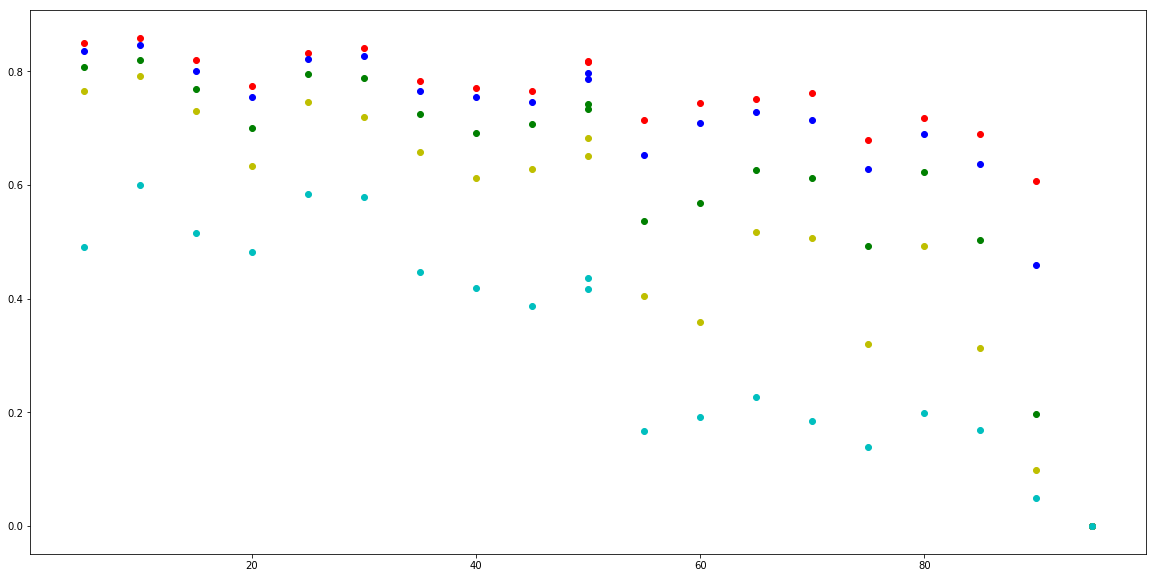

In [89]:
import scipy.stats as stats
fig,ax=plt.subplots(figsize=(20,10))
colors=['r','b','g','y','c']
corrs=[]
for i in range(len(coherances[0])):
    ax.scatter(props,[c[i] for c in coherances],color=colors[i])
    corrs.append(stats.spearmanr(props,[c[i] for c in coherances]))

print(corrs)

[SpearmanrResult(correlation=-0.90560367442282041, pvalue=3.9955313678183348e-08), SpearmanrResult(correlation=-0.92064692482851507, pvalue=8.860423100439015e-09), SpearmanrResult(correlation=-0.93794666279506378, pvalue=1.0330831042793028e-09), SpearmanrResult(correlation=-0.93117720011250116, pvalue=2.5583474504484845e-09), SpearmanrResult(correlation=-0.93117720011250116, pvalue=2.5583474504484845e-09)]


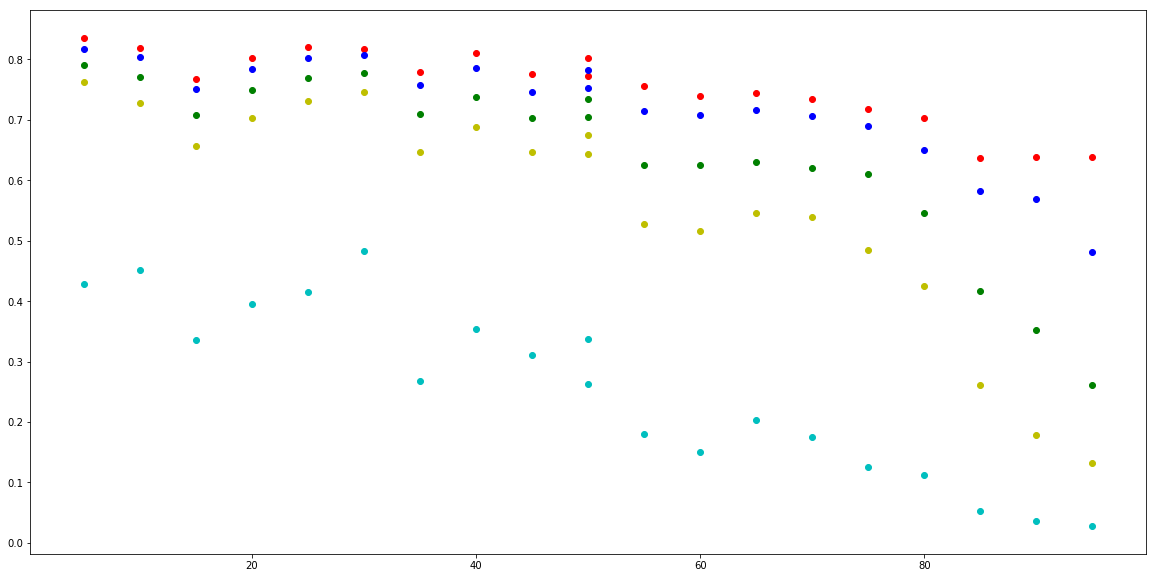

In [90]:
jsd_coherances=[]
for cset in jsd_characteristic_sets:
    jsd_coherances.append(coherance_profile(cset,theft_model,verbose=False))
fig,ax=plt.subplots(figsize=(20,10))
colors=['r','b','g','y','c']
corrs=[]
for i in range(len(jsd_coherances[0])):
    ax.scatter(props,[c[i] for c in jsd_coherances],color=colors[i])
    corrs.append(stats.spearmanr(props,[c[i] for c in jsd_coherances]))

print(corrs)    

[SpearmanrResult(correlation=-0.036103800973667256, pvalue=0.87988634469260441), SpearmanrResult(correlation=0.20082739291602411, pvalue=0.39588308712020948), SpearmanrResult(correlation=-0.14591952893523849, pvalue=0.53931228437368195), SpearmanrResult(correlation=-0.27077850730250441, pvalue=0.24820568499014284), SpearmanrResult(correlation=-0.26175255705908762, pvalue=0.26493783916023605)]


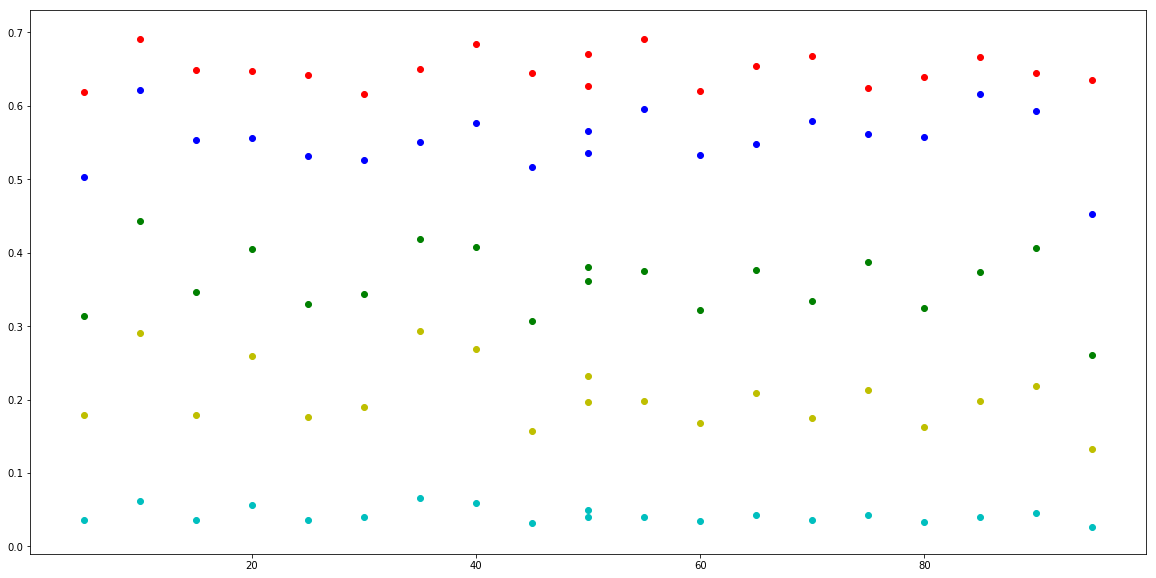

In [91]:
kl_coherances=[]
for cset in kl_characteristic_sets:
    kl_coherances.append(coherance_profile(cset,theft_model,verbose=False))
fig,ax=plt.subplots(figsize=(20,10))
colors=['r','b','g','y','c']
corrs=[]
for i in range(len(kl_coherances[0])):
    ax.scatter(props,[c[i] for c in kl_coherances],color=colors[i])
    corrs.append(stats.spearmanr(props,[c[i] for c in kl_coherances]))

print(corrs) 

Partial KL coherances do not appear correlated with proportion.  Further, they look lower.  This suggests they may not be biased towards low frequency words particularly for small relative corpus sizes.

Whilst partialKL looks appealing we have to remember that we can't just use top k words (semantic coherance is roughly the same for random and non-random splits).  So need to look at the value which distinguishes random from non-random.

In [92]:
vals=[]
for cset in kl_characteristic_sets:
    #print(cset[0],cset[1])
    if(np.isnan(cset[0][1])):
        pass
    else:
        vals.append(cset[0][1])
#print(vals)
#vals=sorted(vals)
kl_thresh=np.percentile(vals,50)
print(kl_thresh)

0.000595449976613


In [93]:
female_words_kl=[]
for (word,score) in femalewords_kl:
    if score>kl_thresh:
        female_words_kl.append((word,score))
print(len(female_words_kl),female_words_kl)

17 [('she', 0.0041039375968628129), ('her', 0.0028761107023999393), ('my', 0.0021755994816825279), ('husband', 0.0014772523159826362), ('room', 0.0011428889012404392), (';', 0.0010897118245451398), ('me', 0.00096987366201654803), ('things', 0.00085672602809175671), ('\n', 0.00081974437090639963), ('came', 0.00078337175618502035), ('out', 0.00077680640405782876), ('went', 0.00077675523497344246), ('door', 0.00075604897414804765), ('stairs', 0.00072762458727973912), ('bed', 0.00065262043574861007), ('no', 0.00063469412845011154), ('mrs.', 0.00063207185239877027)]


In [94]:
male_words_kl=[]
for (word,score) in malewords_kl:
    if score>kl_thresh:
        male_words_kl.append((word,score))
print(len(male_words_kl),male_words_kl)

11 [('him', 0.0026811088407802781), ('he', 0.0022765794777292966), ('his', 0.0013680162643184188), ('of', 0.0013107065164275999), ('am', 0.00099903629910420974), (',', 0.00097444457350182143), ('mr.', 0.00077612107552957181), ('to', 0.00076037965511499745), ('-', 0.00073146826891226516), ('prisoner', 0.00065613394421844653), ('the', 0.00060652772231708065)]


In [95]:
for p,cset in zip(props,characteristic_sets):
    myname="matrix_random_"+str(p)+".csv"
    make_csv(cset,theft_model,myname,threshold=0.6)

## Frequency Profiling

Many of the characteristic words drawn from the random splits appear to be low frequency.  These low frequency words appear to have spuriously high similarities (it would be good to check that this remains for different runs of word2vec ... presumably high similarity because they have very few contexts and these are the same (e.g., a determiner).  The first thing to do though is to examine the frequency profiles of the characteristic word sets.  If all of the characteristic words from the randomn splits are of a very low frequency this would suggest that llr is still biased towards low frequency words.  We could filter below a frequency threshold and rerun the semantic coherance profiling.  It will also be useful to see how the bootstrap method handles low frequency events in random splits.

In [96]:
def frequency_profile(wordsets,corpus,labels=[]):
    allfrequencies=[]
    for wordset in wordsets:
        frequencies=[]
        #print(wordset)
        for (word,score) in wordset:
            frequencies.append(int(corpus.allworddict[word]))
        allfrequencies.append(np.array(frequencies))
    #print(allfrequencies)
    fig,ax=plt.subplots(figsize=(20,10))
    ax.boxplot(allfrequencies,showmeans=True,labels=labels)
    ax.set_title('Frequency Profile of Characteristic Words')
    ax.set_yscale('log')
    plt.show()
    
    

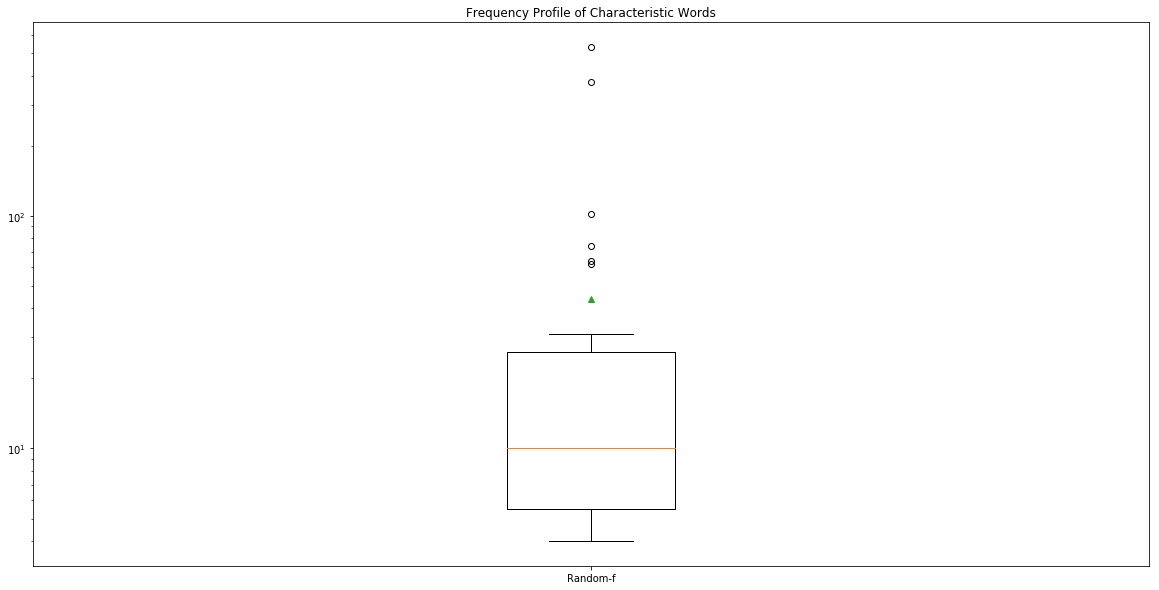

In [97]:
frequency_profile([random_f_words],theft_corpus,labels=['Random-f'])

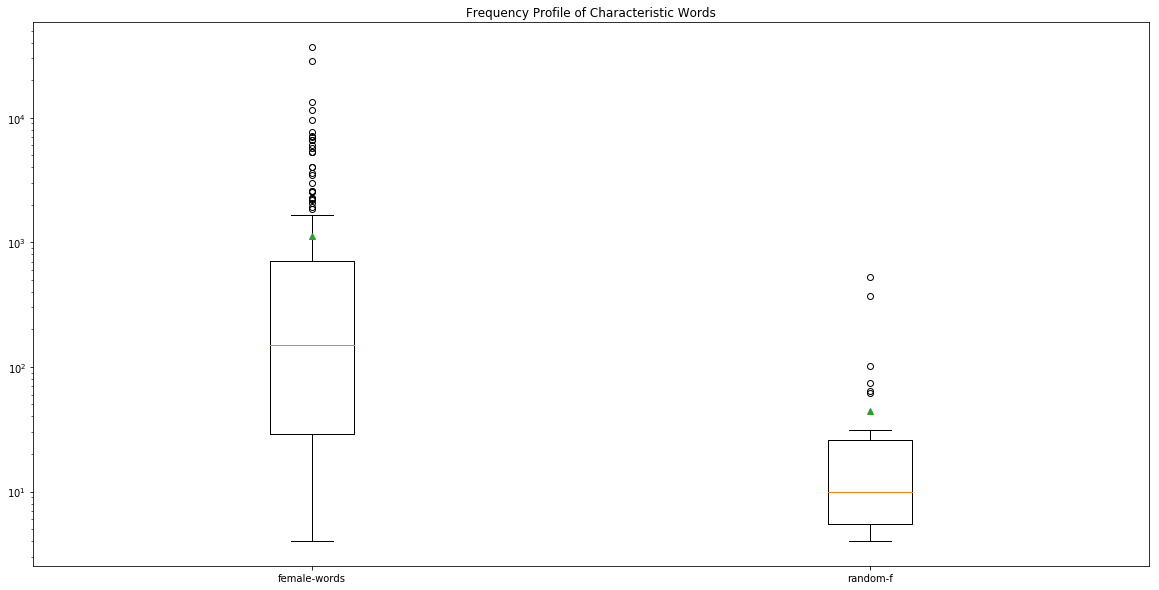

In [98]:
frequency_profile([femalewords,random_f_words],theft_corpus,['female-words','random-f'])

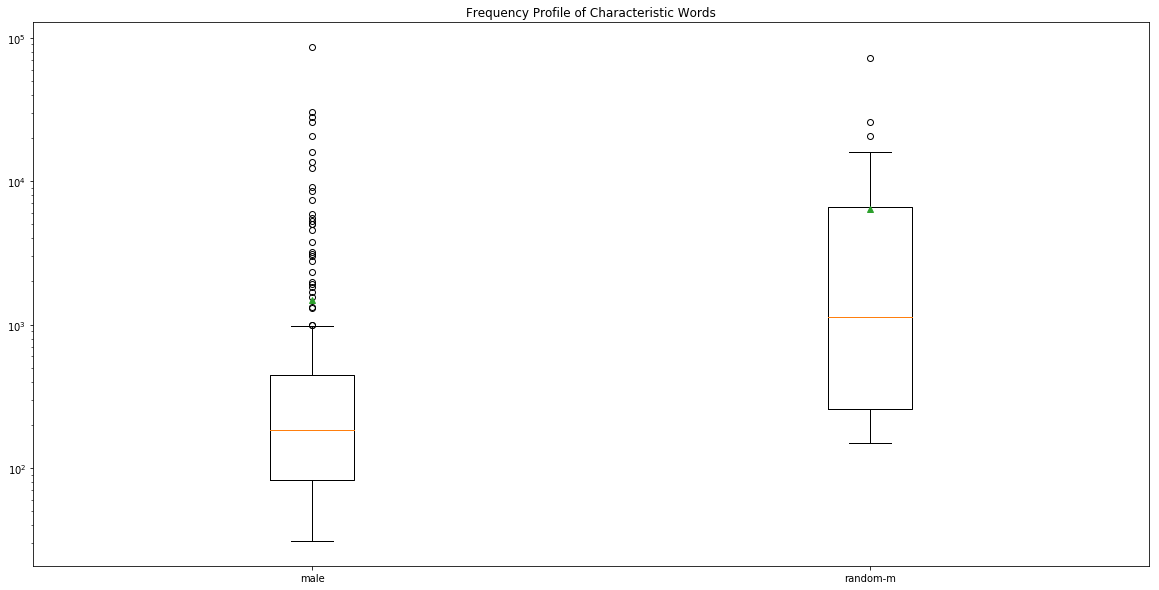

In [99]:
frequency_profile([malewords,random_m_words],theft_corpus,['male','random-m'])

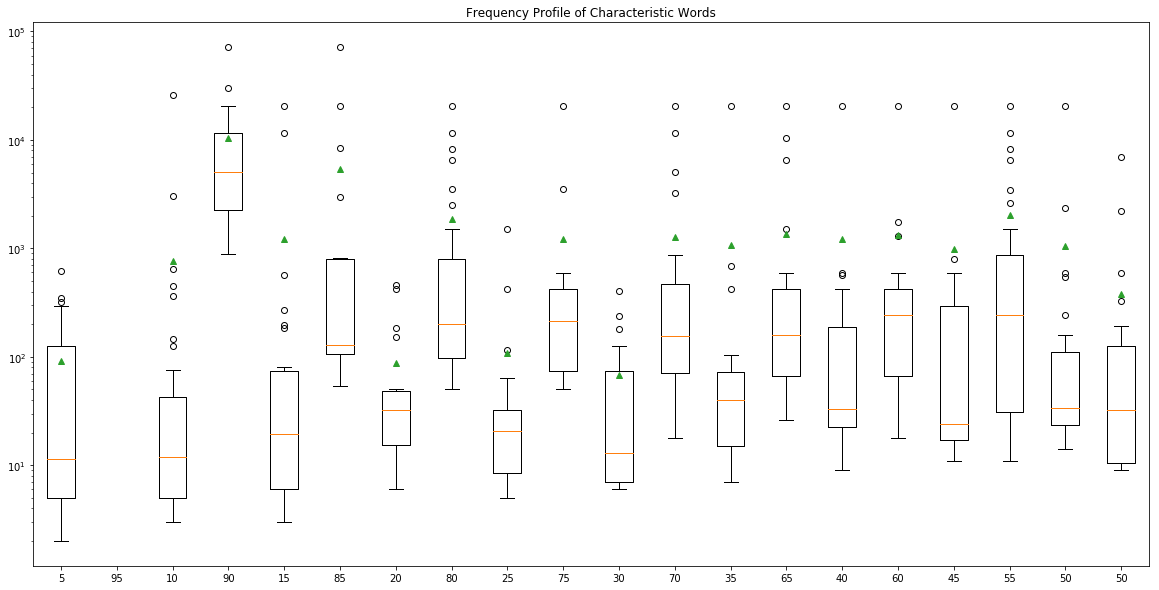

In [100]:

frequency_profile(characteristic_sets,theft_corpus,labels=props)

Clear correlation between split proportion and frequency of characteristic words.  A threshold of at least 10 should be applied to the chracteristic word sets since similarities for lower frequency words these are not reliable.

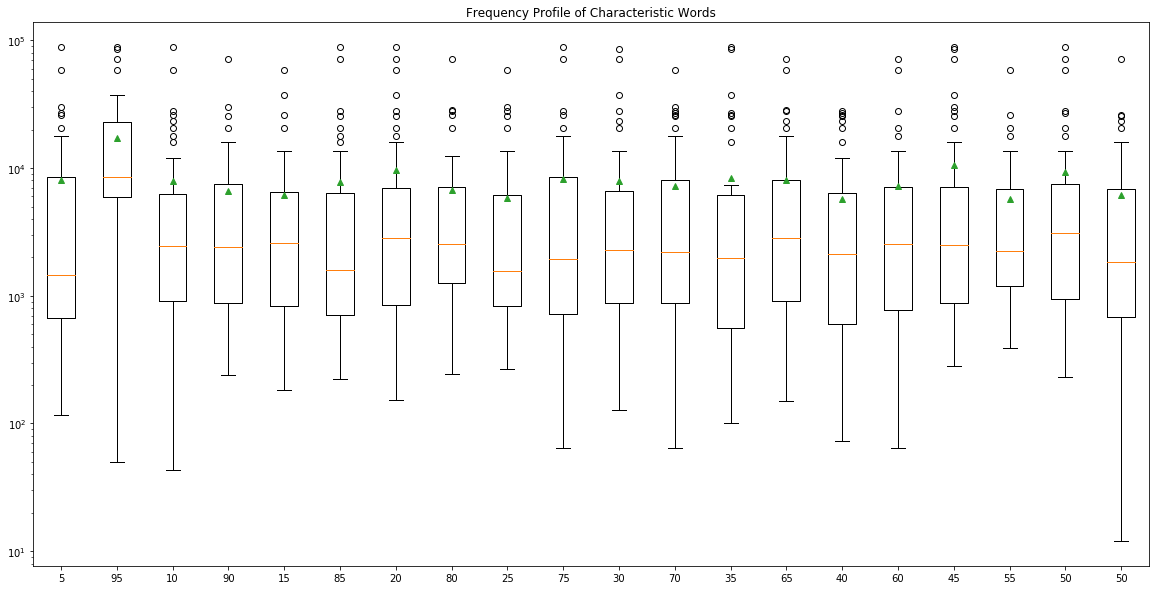

In [101]:
frequency_profile(kl_characteristic_sets,theft_corpus,labels=props)

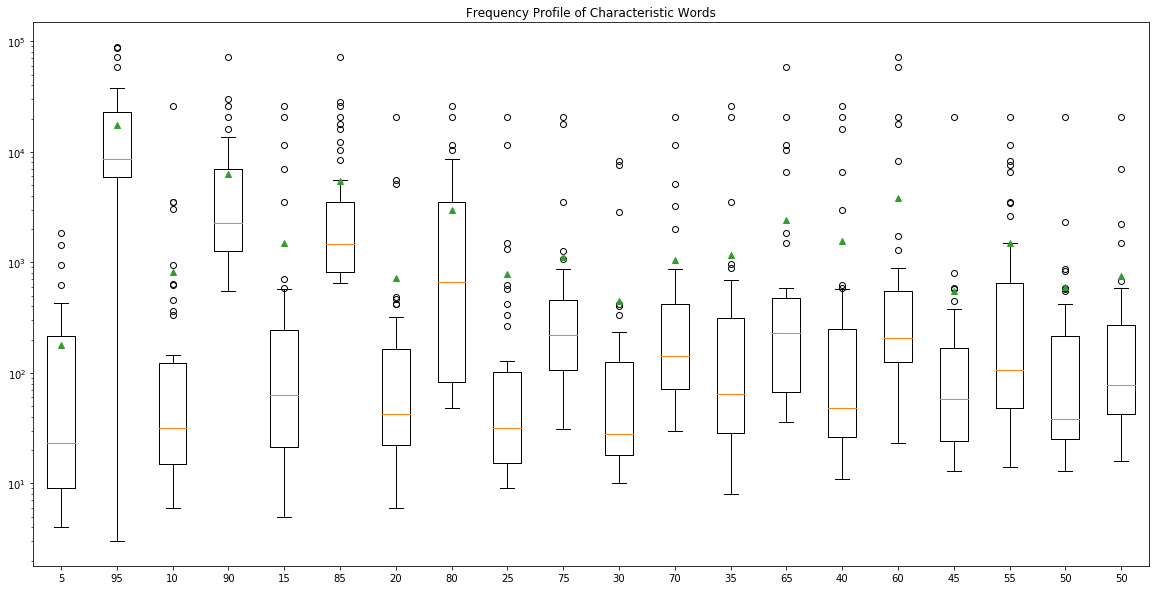

In [102]:
frequency_profile(jsd_characteristic_sets,theft_corpus,labels=props)

## Frequency Thresholding


In [103]:
ft=25
def frequency_threshold(csets,threshold=ft,corpus=theft_corpus):
    tsets=[]
    for cset in csets:
        tset=[]
        for term,score in cset:
            freq=int(corpus.allworddict[term])
            if freq>threshold:
                tset.append((term,score))
        tsets.append(tset)
        
    return tsets


In [104]:
thresholded_sets=frequency_threshold(characteristic_sets)

20 20


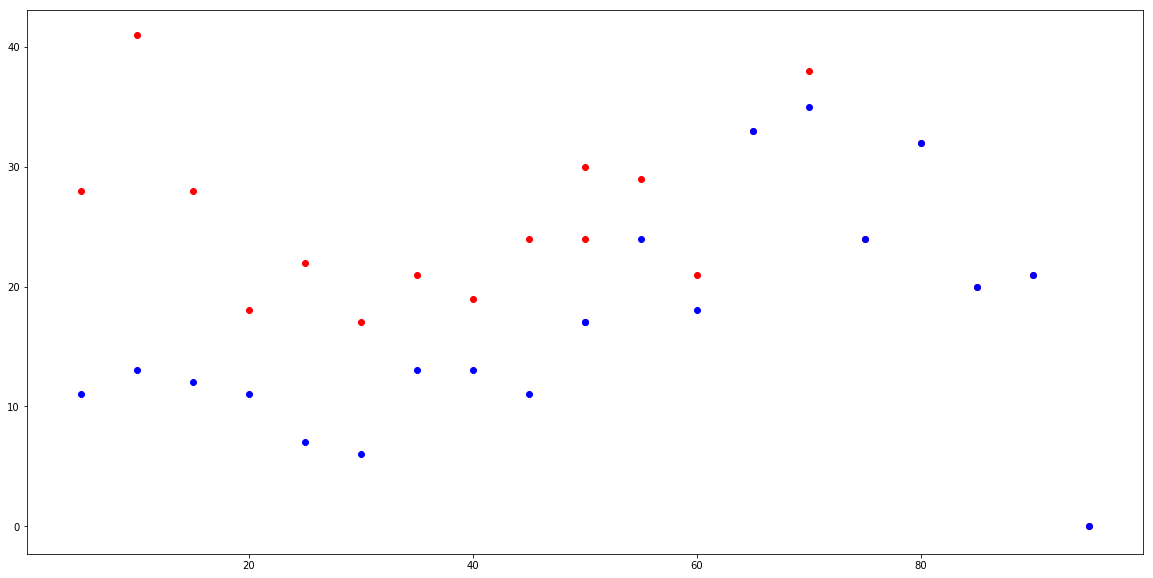

In [105]:
csizes=[len(cset) for cset in characteristic_sets]
tsizes=[len(tset) for tset in thresholded_sets]

print(len(csizes),len(tsizes))
fig,ax=plt.subplots(figsize=(20,10))
ax.scatter(props,csizes,color='r')
ax.scatter(props,tsizes,color='b')

In [106]:
tcoherances=[]
for tset in thresholded_sets:
    tcoherances.append(coherance_profile(tset,theft_model))

Average semantic coherance at k=1: 0.6828706310887097
Average semantic coherance at k=2: 0.6225305249568867
Average semantic coherance at k=5: 0.46056552894735275
Average semantic coherance at k=10: 0.26910380858863014
Average semantic coherance at k=-1: 0.26910380858863014
Average semantic coherance at k=1: 0
Average semantic coherance at k=2: 0
Average semantic coherance at k=5: 0
Average semantic coherance at k=10: 0
Average semantic coherance at k=-1: 0
Average semantic coherance at k=1: 0.6937290993661208
Average semantic coherance at k=2: 0.6127621885787335
Average semantic coherance at k=5: 0.4693978940850953
Average semantic coherance at k=10: 0.28362709888391235
Average semantic coherance at k=-1: 0.23635591573659362
Average semantic coherance at k=1: 0.6068199065492282
Average semantic coherance at k=2: 0.4585418213000153
Average semantic coherance at k=5: 0.19711214431933713
Average semantic coherance at k=10: 0.09855607215966856
Average semantic coherance at k=-1: 0.0492780

[SpearmanrResult(correlation=-0.10229410275872389, pvalue=0.66781730776798098), SpearmanrResult(correlation=0.041368938615660392, pvalue=0.86251904936861834), SpearmanrResult(correlation=0.051899213899646676, pvalue=0.82797350573244999), SpearmanrResult(correlation=0.0090259502434168141, pvalue=0.96987367691577331), SpearmanrResult(correlation=-0.71981953191249082, pvalue=0.0003458754831961086)]


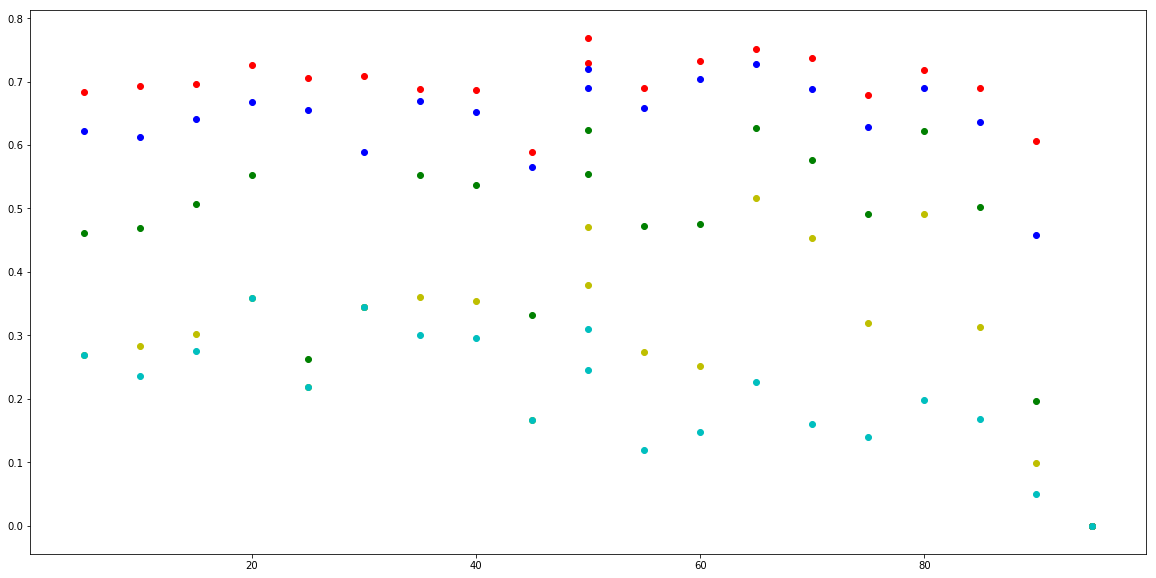

In [107]:
fig,ax=plt.subplots(figsize=(20,10))
colors=['r','b','g','y','c']
tcorrs=[]
for i in range(len(tcoherances[0])):
    ax.scatter(props,[c[i] for c in tcoherances],color=colors[i])
    tcorrs.append(stats.spearmanr(props,[c[i] for c in tcoherances]))

print(tcorrs)

So we need to look at how the (negative) correlation between semantic coherance (at k=1) and corpus proportion goes down as the frequency threshold goes up.


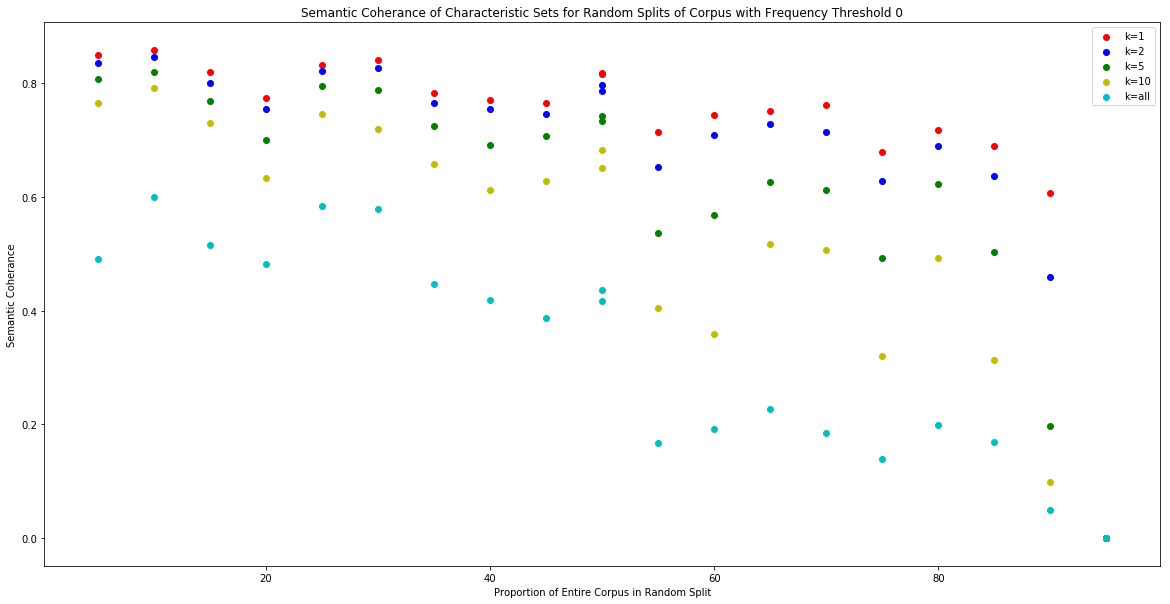

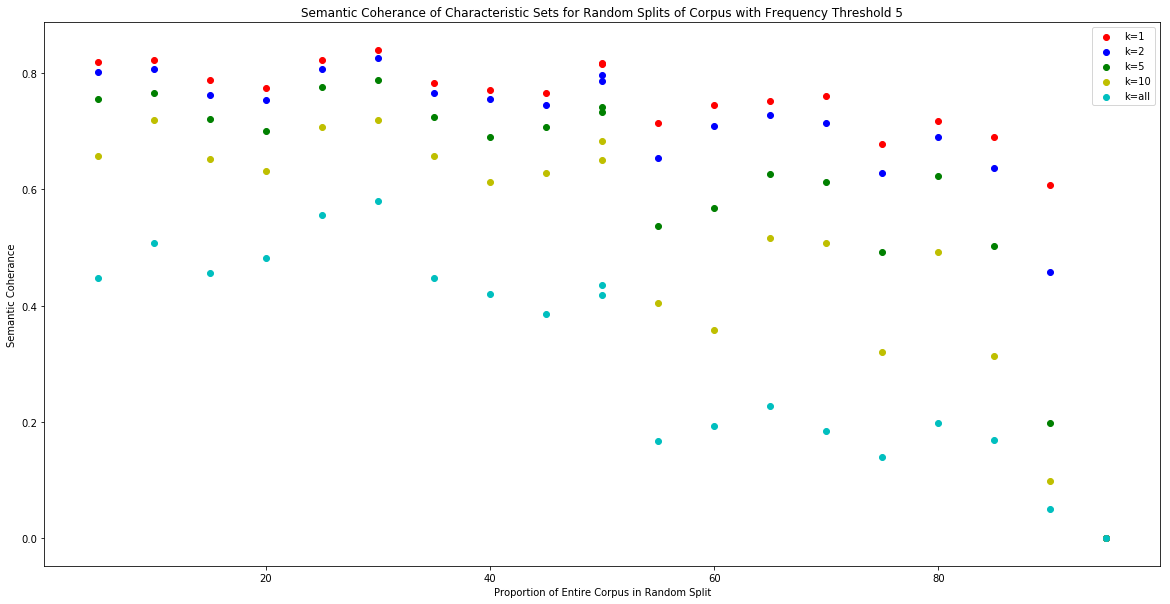

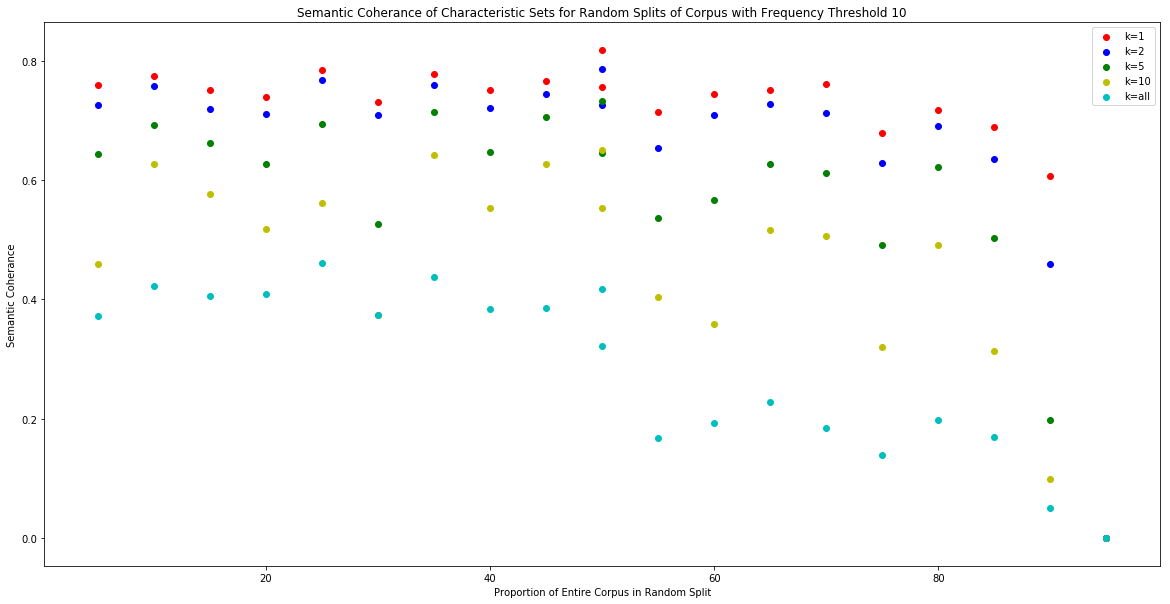

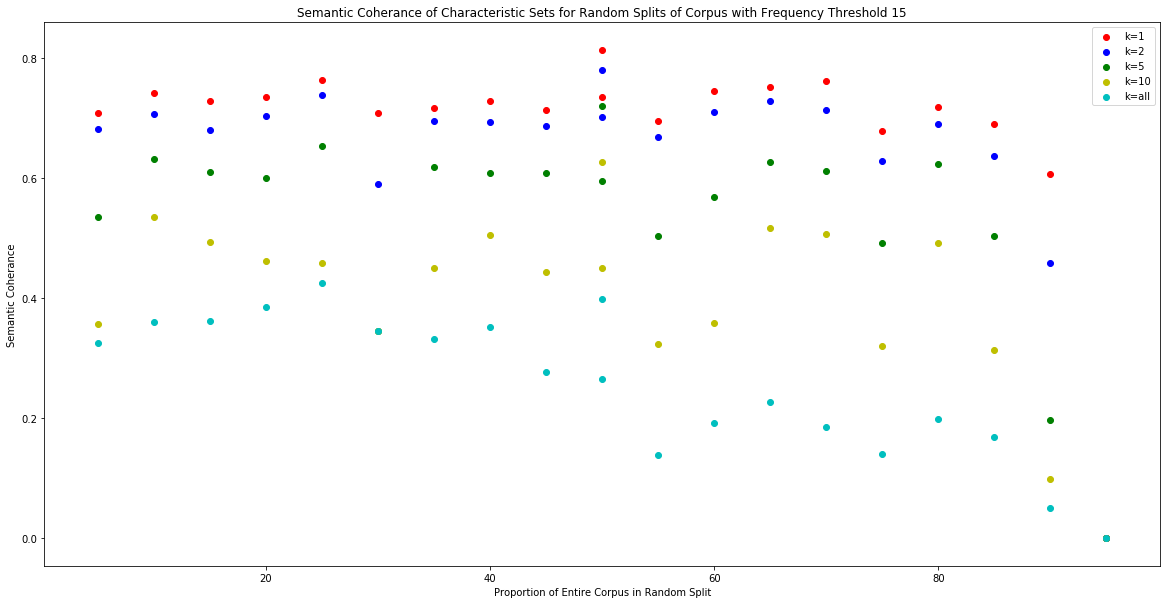

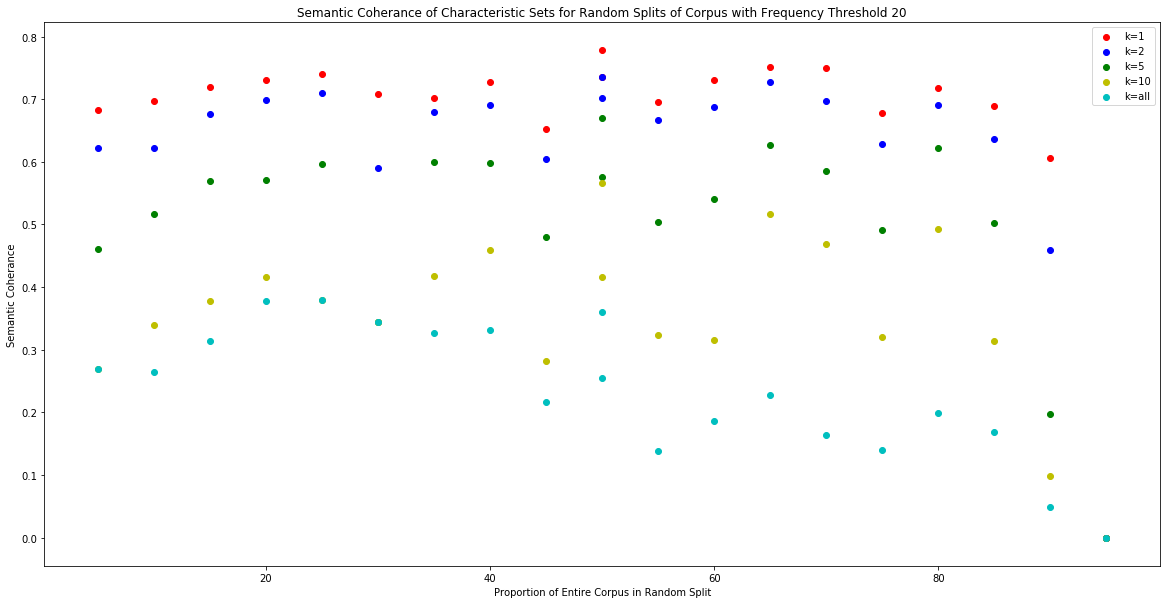

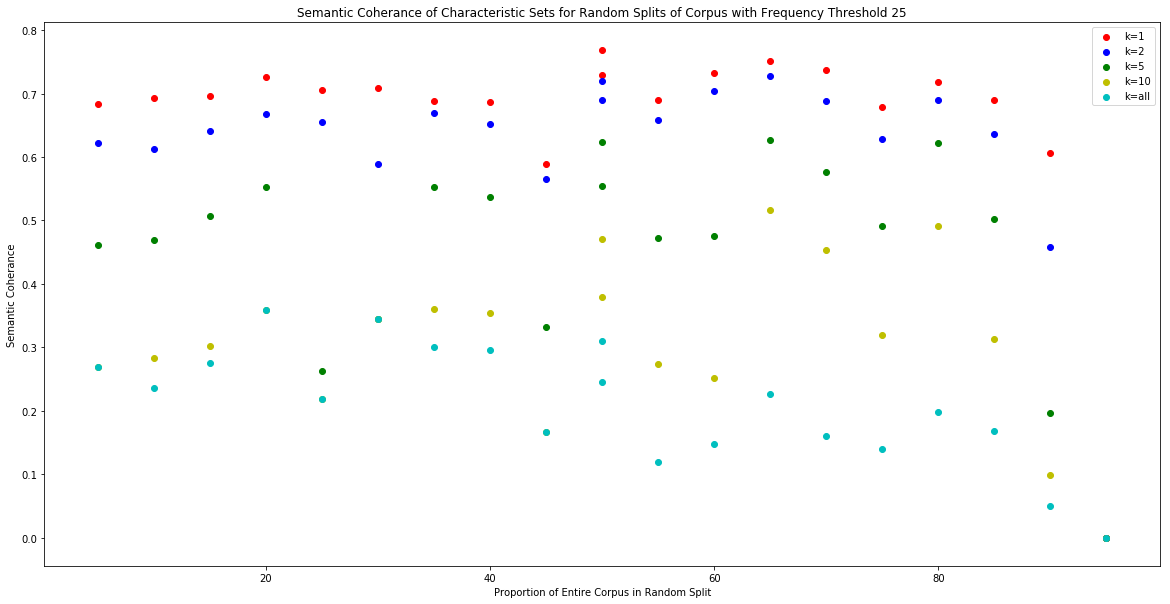

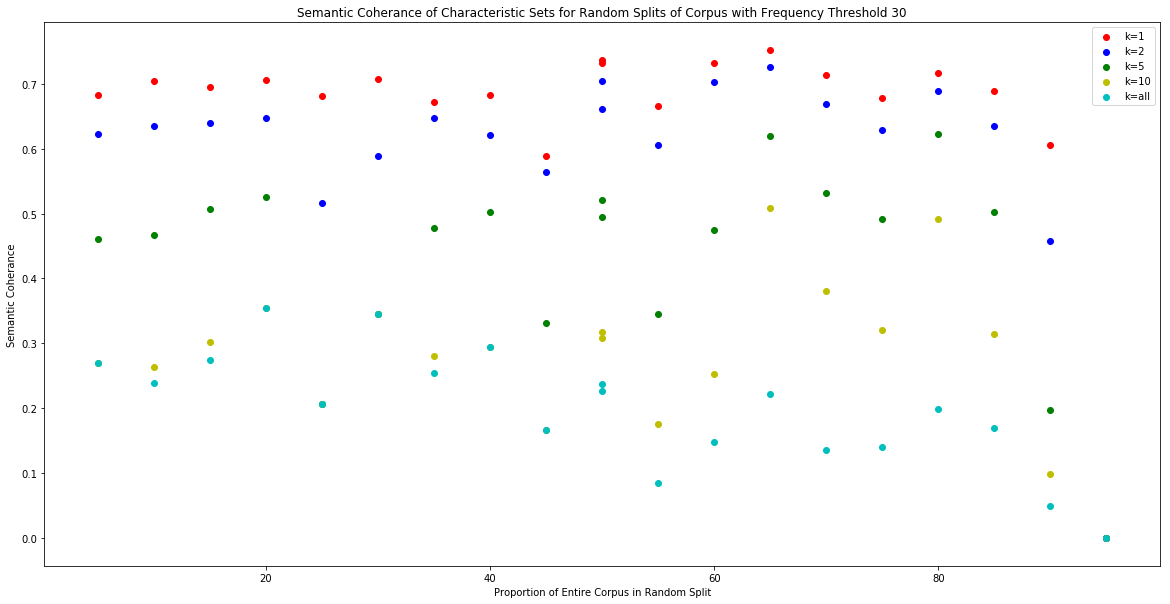

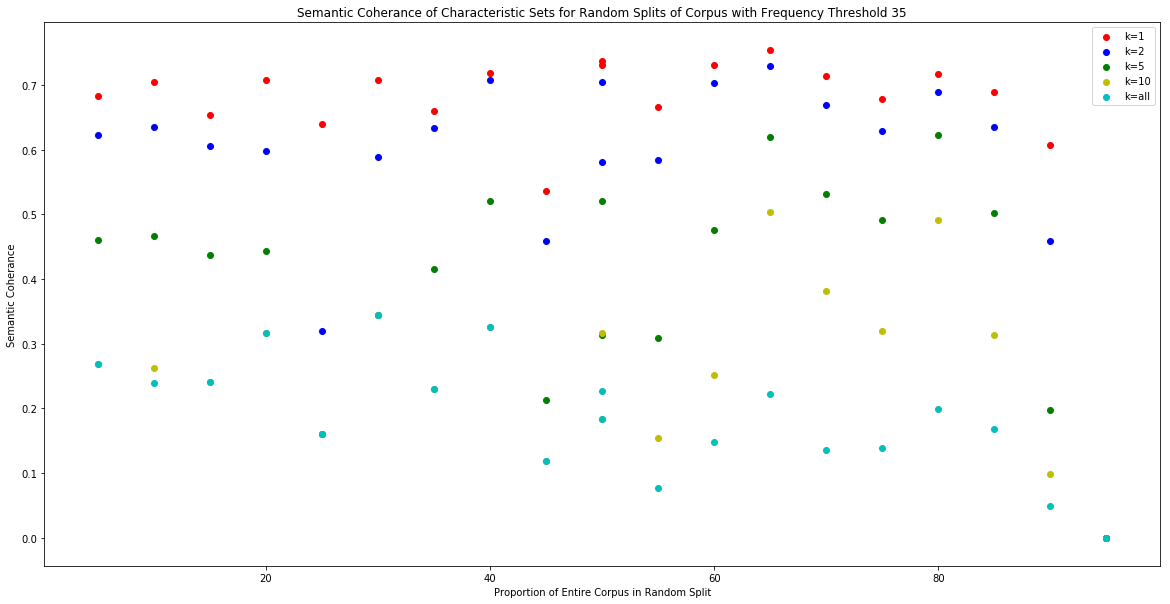

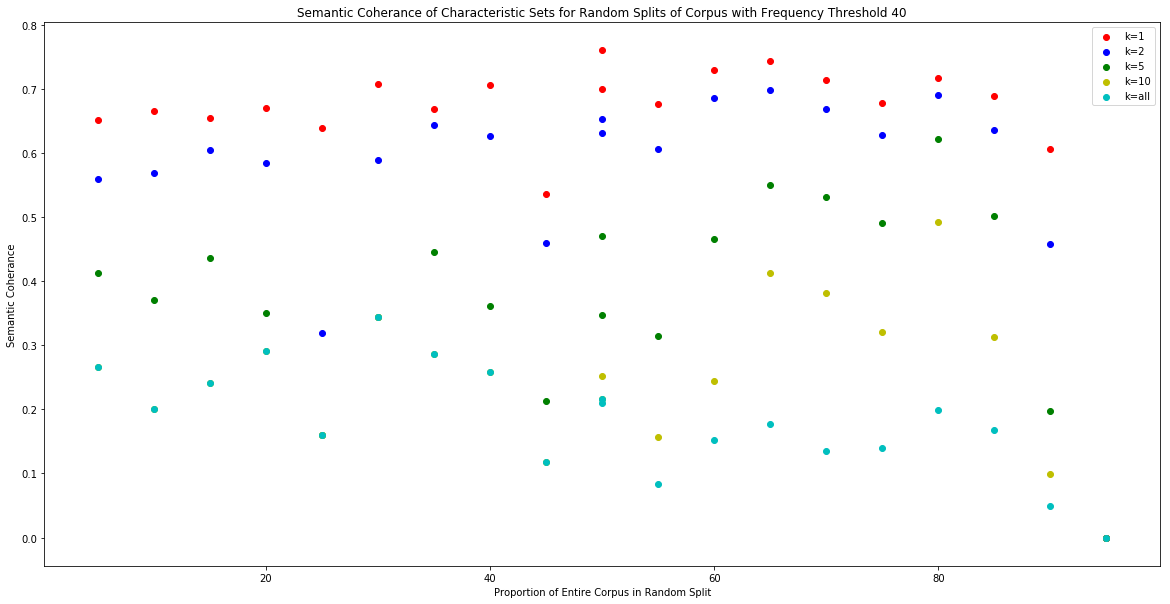

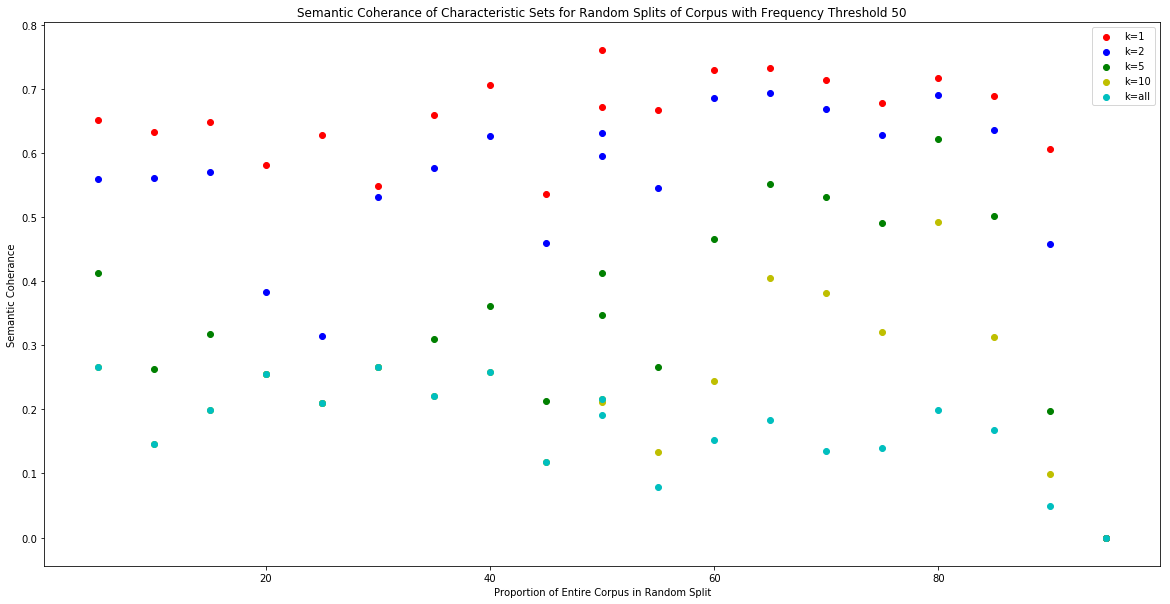

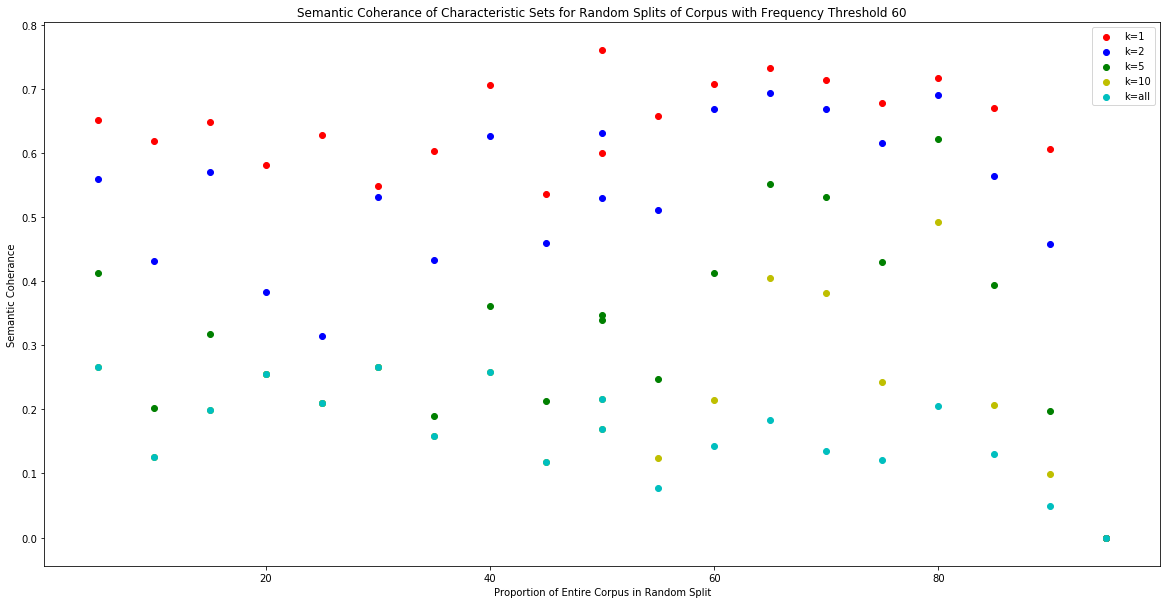

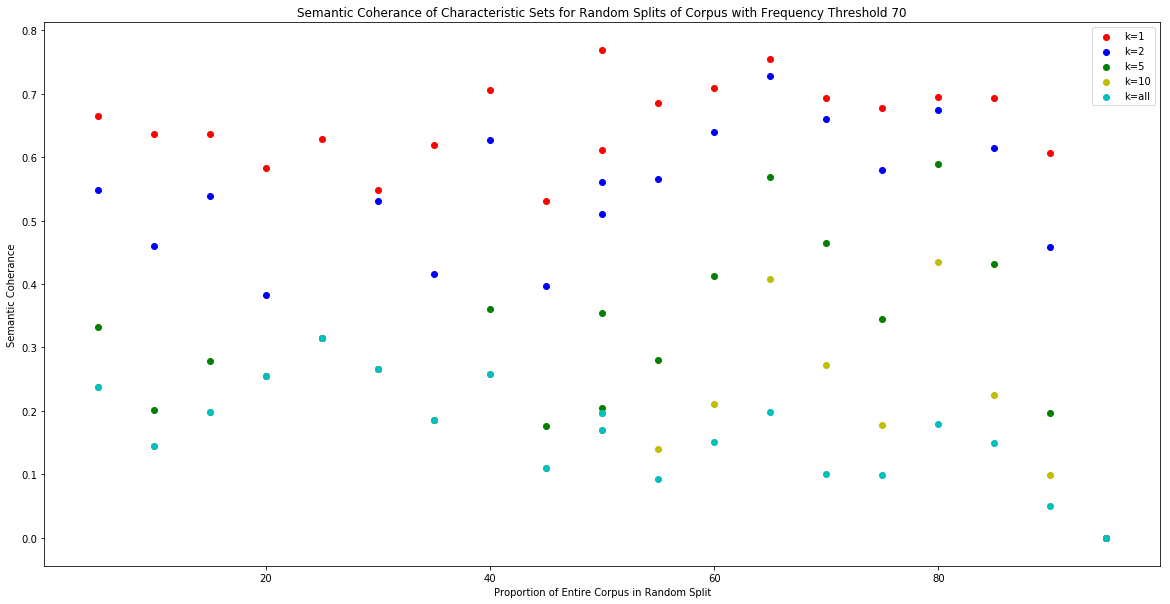

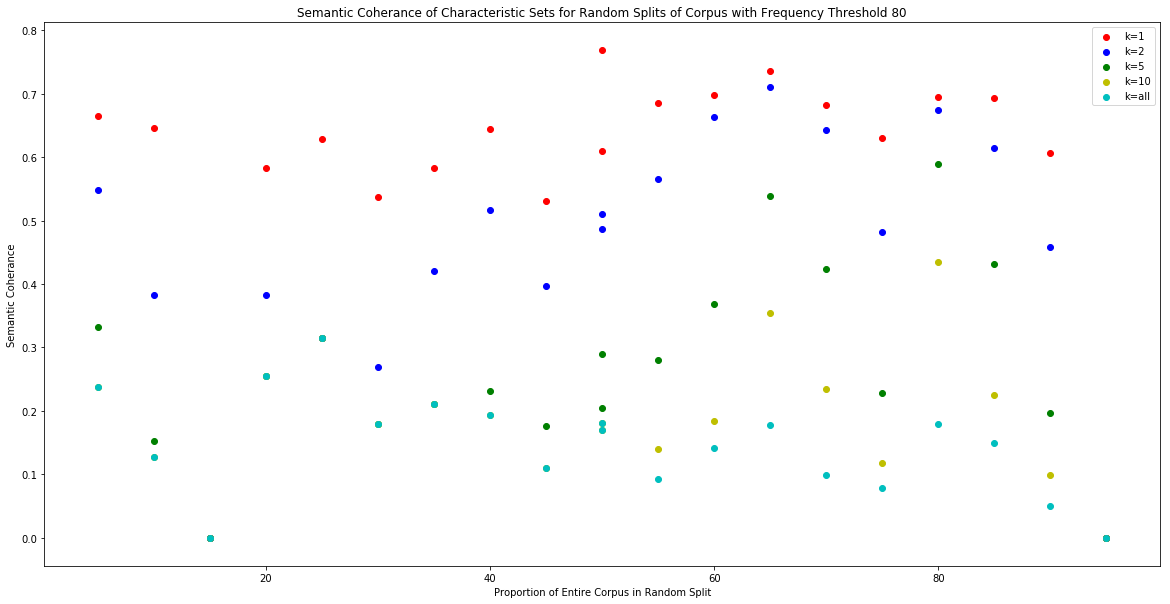

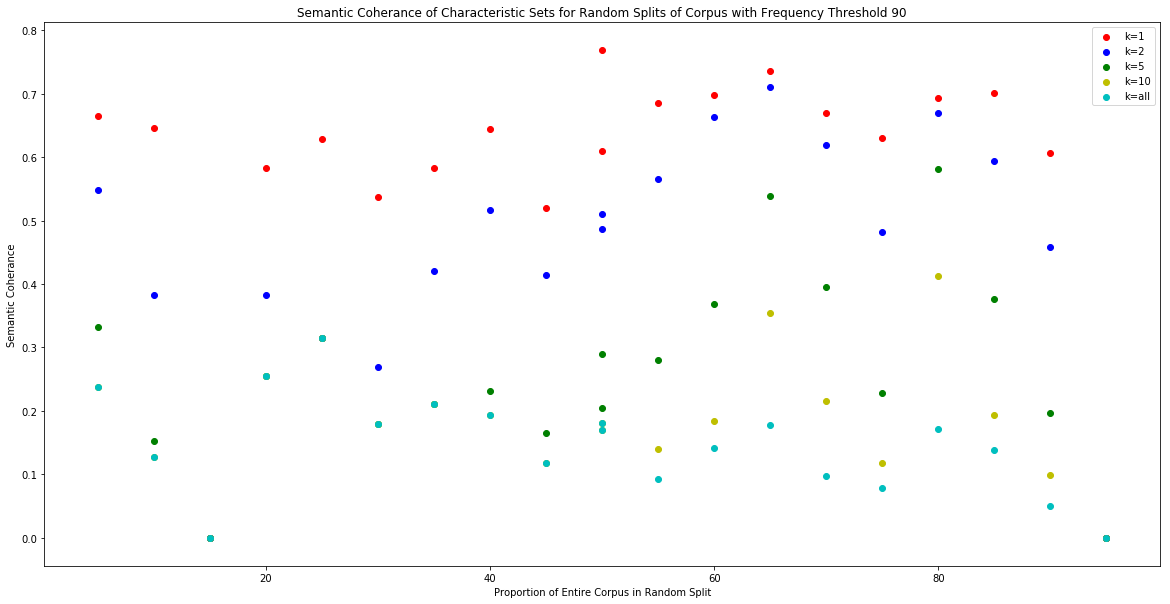

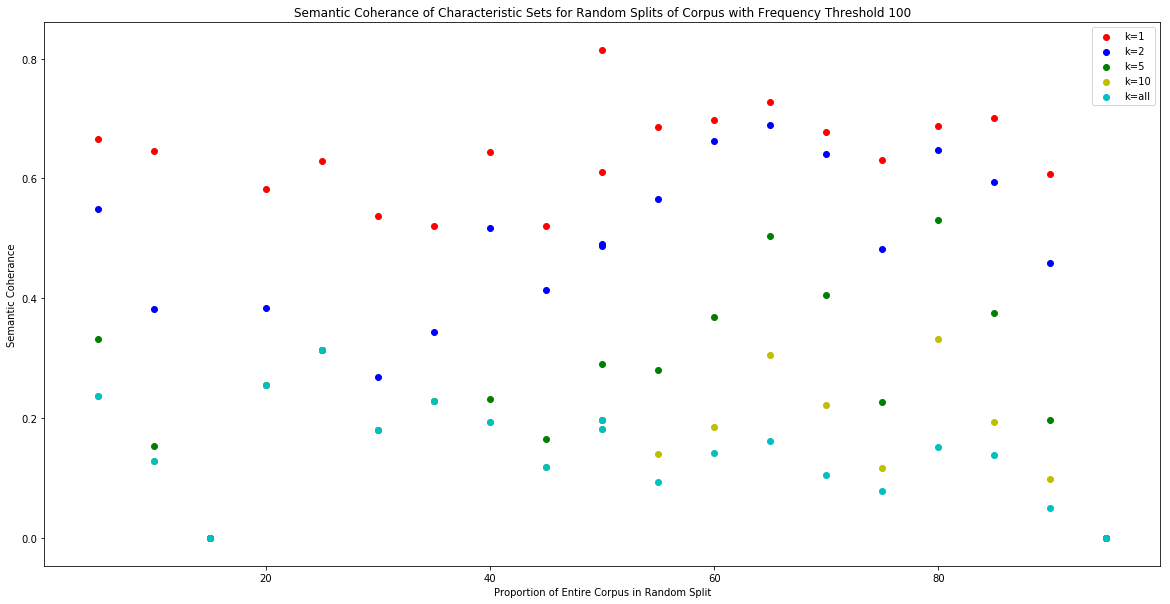

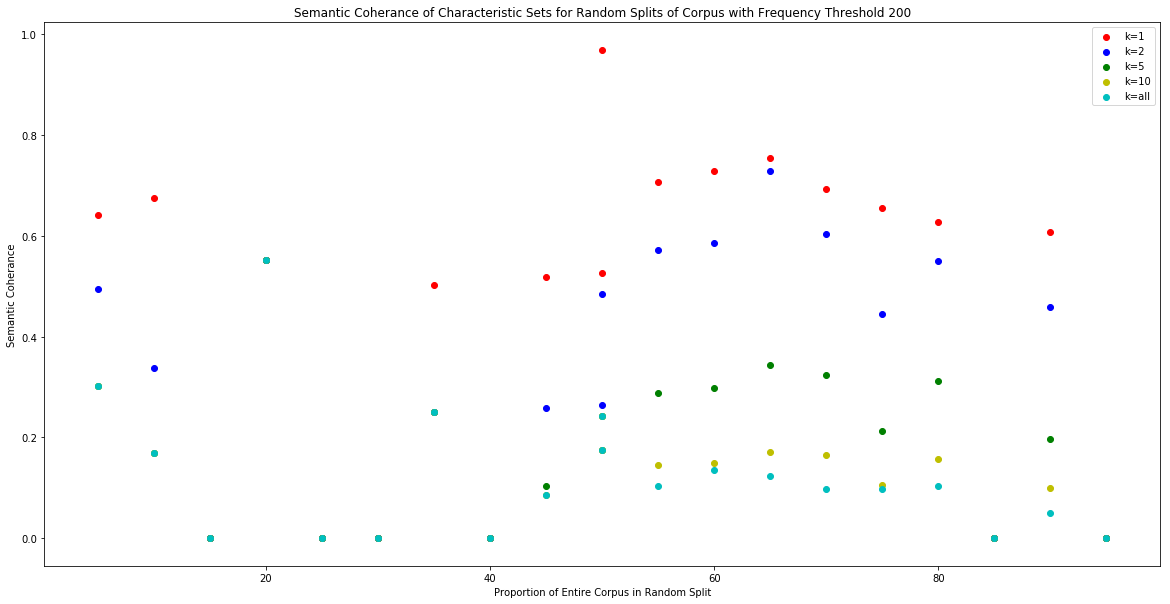

[-0.91086881206481352, -0.86874771092886827, -0.64009030476230899, -0.37081612250037405, -0.22865740616655927, -0.10229410275872389, -0.084994364792174981, 0.0015043250405694689, 0.19330576771317678, 0.27980445754592126, 0.24595714413310815, 0.17450170470605839, 0.25056433408577877, 0.25959367945823925, 0.25658389766741907, 0.14406697240723931]


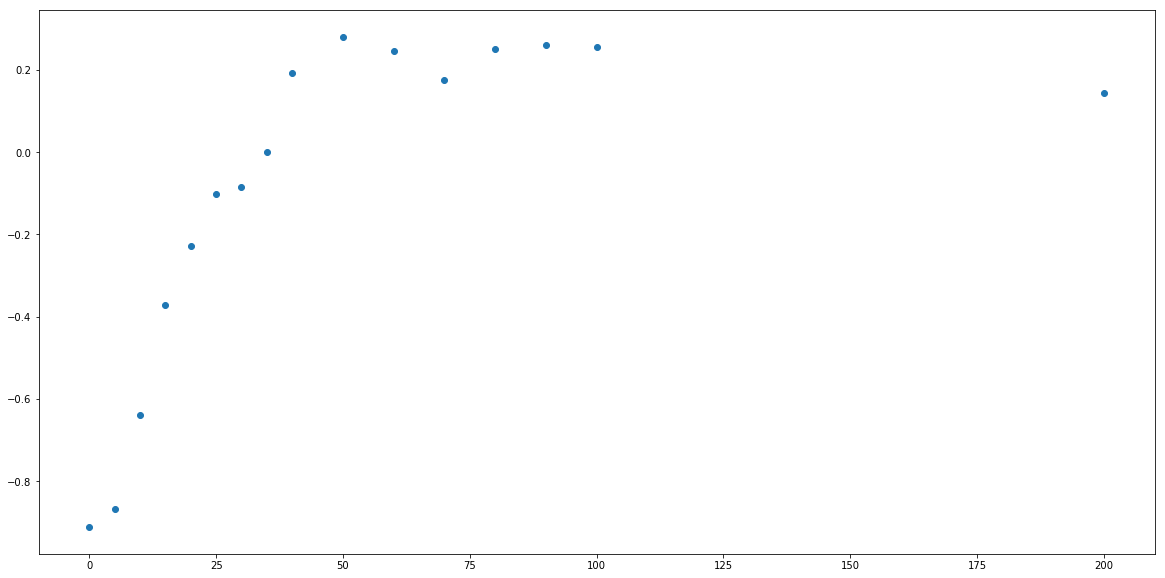

In [108]:
thresholds=[0,5,10,15,20,25,30,35,40,50,60,70,80,90,100,200]
mycorrs=[]
for ft in thresholds:
    tsets=frequency_threshold(characteristic_sets,threshold=ft)
    tcoherances=[]
    for tset in tsets:
        tcoherances.append(coherance_profile(tset,theft_model,verbose=False))
    fig,ax=plt.subplots(figsize=(20,10))
    colors=['r','b','g','y','c']
    tcorrs=[]
    for i in range(len(tcoherances[0])):
        ax.scatter(props,[c[i] for c in tcoherances],color=colors[i])
        tcorrs.append(stats.spearmanr(props,[c[i] for c in tcoherances]))
        ax.set_xlabel('Proportion of Entire Corpus in Random Split')
        ax.set_ylabel('Semantic Coherance')
        ax.legend(['k=1','k=2','k=5','k=10','k=all'])
        ax.set_title("Semantic Coherance of Characteristic Sets for Random Splits of Corpus with Frequency Threshold {}".format(ft))
    plt.show()
    mycorrs.append(tcorrs[0][0])

print(mycorrs)
fig,ax=plt.subplots(figsize=(20,10))
ax.scatter(thresholds,mycorrs)

Correlation between relative corpus size and semantic coherance at k=1 seems to zero out at around a frequency threshold of 35.  However, nearest neighbour similarity is still quite high (0.7).  Is this frequency threshold consistent for other values of k and if we look at the gephi plots?  

Don't print all graphs again.


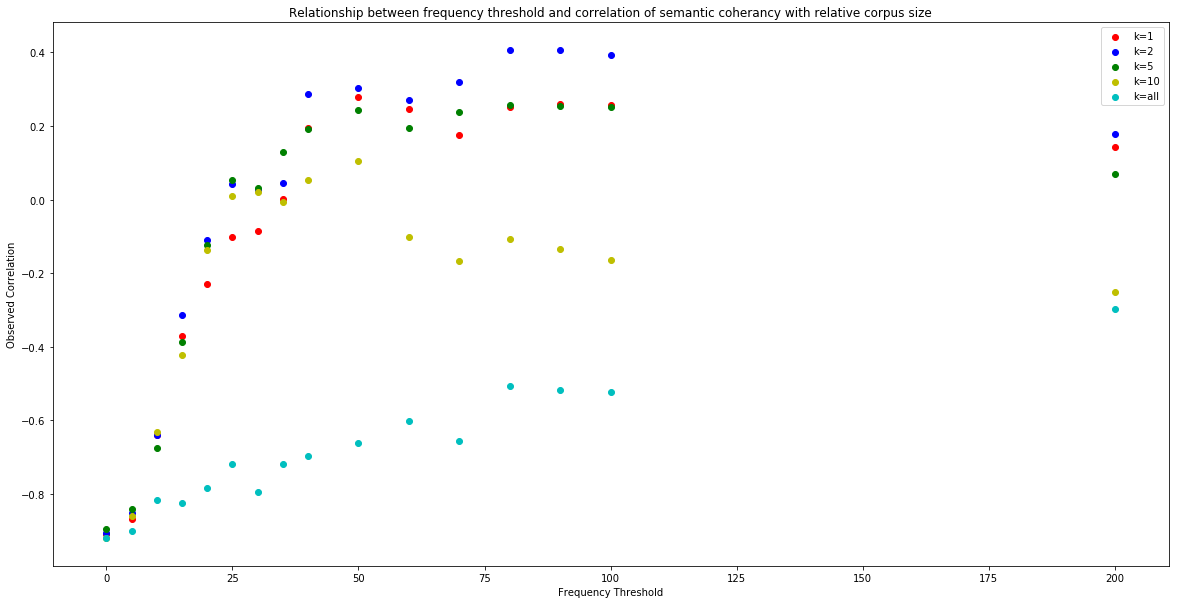

In [109]:
thresholds=[0,5,10,15,20,25,30,35,40,50,60,70,80,90,100,200]
mycorrs=[]
for ft in thresholds:
    tsets=frequency_threshold(characteristic_sets,threshold=ft)
    tcoherances=[]
    for tset in tsets:
        tcoherances.append(coherance_profile(tset,theft_model,verbose=False))
    
    tcorrs=[]
    for i in range(len(tcoherances[0])):
        tcorrs.append(stats.spearmanr(props,[c[i] for c in tcoherances]))
        
    mycorrs.append([tcorr[0] for tcorr in tcorrs])
colors=['r','b','g','y','c']
#print(mycorrs)
fig,ax=plt.subplots(figsize=(20,10))
for i in range(len(mycorrs[0])):
    
    ax.scatter(thresholds,[mycorr[i] for mycorr in mycorrs],color=colors[i])
ax.set_title('Relationship between frequency threshold and correlation of semantic coherancy with relative corpus size')
ax.set_xlabel('Frequency Threshold')
ax.set_ylabel('Observed Correlation')
ax.legend(['k=1','k=2','k=5','k=10','k=all'])

With a frequency threshold of 25+, it would appear reasonable to estimate semantic coherance of characteristic sets based on the first 1-10 neighbours and expect this not to be correlated with the relative size of the splits of the corpus.  k=10 and k=all do not appear to be as asymptotic as k=1,2, and 5.  k=5 potentially looks the most stable.

Need to check gephi plots and see how these parameters work for female/male splits.  Also what happens when you do bootstrap rather than llr.


In [110]:
for p,cset in zip(props,thresholded_sets):
    myname="matrix_random_ft"+str(ft)+"_"+str(p)+".csv"
    make_csv(cset,theft_model,myname,threshold=0.6)

In [111]:
thresholded_gender=frequency_threshold([femalewords,malewords])

In [112]:
coherance_profile(thresholded_gender[0],theft_model)

Average semantic coherance at k=1: 0.7694678720625883
Average semantic coherance at k=2: 0.7471449902400636
Average semantic coherance at k=5: 0.7001711769189453
Average semantic coherance at k=10: 0.6453699842557572
Average semantic coherance at k=-1: 0.16362763133686758


[0.76946787206258827,
 0.74714499024006364,
 0.70017117691894526,
 0.6453699842557572,
 0.16362763133686758]

In [113]:
coherance_profile(thresholded_gender[1],theft_model)

Average semantic coherance at k=1: 0.7740582915407419
Average semantic coherance at k=2: 0.74835596974148
Average semantic coherance at k=5: 0.7076411238084952
Average semantic coherance at k=10: 0.6701474744495151
Average semantic coherance at k=-1: 0.1710101328342932


[0.77405829154074191,
 0.74835596974148,
 0.7076411238084952,
 0.67014747444951506,
 0.1710101328342932]

In [114]:
thresholded_random_gender=frequency_threshold([random_f_words,random_m_words])

In [115]:
coherance_profile(thresholded_random_gender[0],theft_model)

Average semantic coherance at k=1: 0.7542896232546142
Average semantic coherance at k=2: 0.7408452668506572
Average semantic coherance at k=5: 0.6956740514421041
Average semantic coherance at k=10: 0.5526910506623874
Average semantic coherance at k=-1: 0.5526910506623874


[0.75428962325461424,
 0.74084526685065721,
 0.69567405144210415,
 0.55269105066238744,
 0.55269105066238744]

In [116]:
coherance_profile(thresholded_random_gender[1],theft_model)

Average semantic coherance at k=1: 0.6437422602980434
Average semantic coherance at k=2: 0.5711309653423688
Average semantic coherance at k=5: 0.3244756974752191
Average semantic coherance at k=10: 0.17216331783164673
Average semantic coherance at k=-1: 0.055536554139240885


[0.64374226029804338,
 0.57113096534236885,
 0.32447569747521909,
 0.17216331783164673,
 0.055536554139240885]

In [117]:
print(thresholded_random_gender[0])

[('pig', 28.640268794594935), ('jennings', 23.967198193204268), ('drover', 20.770461170262301), ('stall', 15.42807704959853), ('shoes', 14.083822078316501), ('head', 13.129853768218297), ('boxes', 12.743549891460141), ('mr', 12.64044640026003), ('latch', 12.206272717627659), ('barn', 11.477901218994855), ('stove', 11.209073586244701)]


In [118]:
make_csv(thresholded_gender[0],theft_model,'matrix_female_ft25.csv',threshold=0.6)

In [119]:
make_csv(thresholded_gender[1],theft_model,'matrix_male_ft25.csv',threshold=0.6)

In [120]:
make_csv(thresholded_random_gender[0],theft_model,'matrix_f_random_ft25.csv',threshold=0.6)

In [121]:
make_csv(thresholded_random_gender[1],theft_model,'matrix_m_random_ft25.csv',threshold=0.6)

Whilst frequency thresholding appears to bring down the correlation between semantic coherance and size of split, there appears still to be a tendancy for characteristic words of random splits to be semantically coherant.  This is because (presumably) they are characteristic of certain long speeches i.e., they co-occur together in speeches.  If someone mentions a drover they are more likely to mention a pig, independently of any of their demographic characteristics.  This would be more evidence that BOW is broken for this kind of analysis.

However, looking at the transcripts, very little evidence of this.  The characteristic words for random-f [pig,stove,barn, stall, drover,...],do not tend to co-occur.  There is one long speech which continually refers to "Mr Jennings" and there are some random-seeming co-occurrences of "shoes" and "boxes" with "stove" or "drover".  Looking at the random-25 set, there is some evidence for these kind of co-occurrences.  16 out of 26 occurrences of "kettle" are collocated with "tea" as a "tea kettle" or "tea-kettle".

Bootstrapping will not completely overcome this potential problem - if "kettle" is found to be a charcteristic word, it is still extremely likely that "tea" will be found to be a characteristic word. However, for either to be found a characteristic word, the occurrences will need to be distributed across a larger number of speeches/trials.